---
---

# IMPORTS

In [1]:
INTERACTIVE = False
FIGWIDTH    = 12


# CHOOSE INTERACTIVE ON/OFF
if INTERACTIVE:
    %matplotlib widget
else:
    %matplotlib inline
#----------------------
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mpldates
import pandas as pd
from scipy.interpolate import interp1d
import glob
import sys
sys.path.append('../')

import pynumdiff
import fillingpatterns as fp

# Make sure this import is after pandas
import Backend.ABPPandas

import Backend.Constants as cst
import Backend.NXCALS as nx


# Matplotlib config
for key in plt.rcParams.keys():
    if 'date.auto' in key:
        plt.rcParams[key] = "%H:%M"


# Creating NXCALS variable containers
wires     = {'B1': [nx.NXCALSWire(loc = loc) for loc in ['L1B1','L5B1']],
             'B2': [nx.NXCALSWire(loc = loc) for loc in ['R1B2','R5B2']]}
beams     = [nx.NXCALSBeam(name) for name in ['B1','B2']]

buckets   = np.arange(3564)


# Locating data
DATA_PATH = '/eos/project/l/lhc-lumimod/LuminosityFollowUp/2022_test_v0.2.2/'
SAVEPATH  = '../Results_Lumi_V2/wires_on'

def importData(_fill,columns):
    # Importing fill data
    df = pd.read_parquet(DATA_PATH+f'HX:FILLN={FILL}',columns=columns)
    df = df.sort_index()
    df.index.name = 'unix'
    df.insert(0,'Timestamp',df.index)
    df.insert(1,'Time',1e-9*(df.index - df.index[0]))
    df['Timestamp'] = df['Timestamp'].apply(lambda t: pd.Timestamp(t).tz_localize('UTC'))
    return df

def wireROI(df):
    wire_start = df[df[wires['B1'][0]['I']]>10]['Timestamp'].min()
    wire_stop  = df[(df[wires['B1'][0]['I']]>295)&(df['Timestamp']>wire_start)]['Timestamp'].min()
    wire_start,wire_stop = wire_start-pd.Timedelta(minutes=3),wire_stop+pd.Timedelta(minutes=3)
    return wire_start,wire_stop


def getFillingPatt(df):

    filled_buckets = {}
    patterns       = {}
    bunch_I        = {}
    for beam in beams:
        
        filled_ts = np.min(df[df[beam['Intensity']]== np.max(df[beam['Intensity']])].index)

        sub = df.dropna(subset=[beam['bb_Intensity']])
        _ts = sub.index[sub.index.get_loc(filled_ts, method='nearest')]
        
        
        bunch_I[beam.name]        =df.loc[_ts,beam['bb_Intensity']]
        filled_buckets[beam.name] = np.arange(len(buckets))[bunch_I[beam.name]!=0]
        patterns[beam.name]       = (bunch_I[beam.name]!=0)


    # Figuring out filling patterns
    patt = fp.FillingPattern(patterns['B1'], patterns['B2'])
    patt.compute_beam_beam_schedule(n_lr_per_side=21)

    for bb_patt in [patt.b1,patt.b2]:
        train_num     = np.repeat(np.arange(len(bb_patt.train_lengths)),bb_patt.train_lengths)
        train_lengths = np.repeat(bb_patt.train_lengths,bb_patt.train_lengths)
        bb_patt.bb_schedule.insert(0,'Train',train_num)
        bb_patt.bb_schedule.insert(1,'Train Lengths',train_lengths)
        bb_patt.bb_schedule.insert(2,'Tag',None)


        targetTrain = bb_patt.bb_schedule['Train Lengths'].max()

        grouped = bb_patt.bb_schedule.groupby('Train')
        for train in list(grouped.groups.keys()):
            if grouped.get_group(train)['Train Lengths'].max() == targetTrain:
                _first  = grouped.get_group(train).index[0]
                _middle = grouped.get_group(train).index[targetTrain//2]

                bb_patt.bb_schedule.loc[_first,'Tag']  = 'first'
                bb_patt.bb_schedule.loc[_middle,'Tag'] = 'middle'

    return patt


2022-09-22 13:43:57,682 [INFO] 
Limited Linear Model Support Detected! 
---> PYCHEBFUN is not installed. 
---> Install pychebfun to use chebfun derivatives (https://github.com/pychebfun/pychebfun/) 
You can still use other methods 



# Import single fill

In [2]:

FILL = 8102


# Importing some data for timescales
#-----------------------------------
var_needed  = ['HX:BMODE']
var_needed += [wire.I for wire in wires['B1']+wires['B2']]
var_needed += [beam['Intensity'] for beam in beams] + [beam['bb_Intensity'] for beam in beams]+ [beam['bb_Intensity_B'] for beam in beams]
var_needed += [beam['bb_Emittance_H'] for beam in beams] + [beam['bb_Emittance_V'] for beam in beams]

database             = importData(FILL,columns=var_needed)
wire_start,wire_stop = wireROI(database)
start_ts             = database[database['HX:BMODE'] == 'STABLE']['Timestamp'].iloc[0]
stop_ts              = wire_start+pd.Timedelta(hours=2)
patt                 = getFillingPatt(database) 
#-----------------------------------

# Loading effective cross section df
#-----------------------------------
xsection_df = {}
xsection_smooth_df = {}
for beam in beams:
    xsection_df[beam.name]        = pd.read_pickle(f"{SAVEPATH}/pickles/xsection_F{FILL}_{beam.name}.pkl")
    xsection_smooth_df[beam.name] = pd.read_pickle(f"{SAVEPATH}/pickles/xsection_smooth_F{FILL}_{beam.name}.pkl")
#-----------------------------------



Computing collision schedules...
Done Beam 1
Done Beam 2


# Test emittance

# Getting bb_parameters

In [3]:


def make_bb_parameters(df,_times):

    STABLE_start = df[df['HX:BMODE'] == 'STABLE']['Time'].iloc[0]

    # Computing avg (every 60 seconds)
    binWind = 60
    bins    = np.arange(_times[0]-binWind/2,_times[-1]+binWind/2+binWind/8,binWind)


    new_dict = {}
    for beam in beams:

        # INTENSITY
        observable = beam['Intensity']
        times,ref  = df.bin(observable,bins=bins)[['Time',observable]].T.to_numpy()
        STABLE_idx = np.argmin(np.abs(times-STABLE_start))

        observable = beam['bb_Intensity']
        total_A    = df.bin(observable,bins=bins)[observable]
        calib_A   = np.mean((ref/total_A.apply(lambda line:np.sum(line)))[STABLE_idx:STABLE_idx+int(10*(60/binWind))])

        new_dict[f'bb_Intensity_A_{beam.name}'] = total_A*calib_A

        observable = beam['bb_Intensity_B']
        total_B    = df.bin(observable,bins=bins)[observable]

        # B1 BCTFR-B needs rolling of 1 bucket (let's make it general):
        #-------------------------------------        
        rolling = buckets[(total_A.loc[STABLE_idx]!=0)&(buckets<3562)][-1]-buckets[(total_B.loc[STABLE_idx]!=0)&(buckets<3562)][-1]
        if rolling != 0 :
            total_B = total_B.apply(lambda line: np.roll(line,rolling))
            print(f'MISALIGNED {beam.name}, ROLLING BY {rolling}')
        #-------------------------------------
       
        calib_B   = np.mean((ref/total_B.apply(lambda line:np.sum(line)))[STABLE_idx:STABLE_idx+int(10*(60/binWind))])
        new_dict[f'bb_Intensity_B_{beam.name}']   = total_B*calib_B
        new_dict[f'bb_Intensity_avg_{beam.name}'] = (total_A*calib_A + total_B*calib_B)/2

        # Emittance:
        for plane in ['H','V']:
            observable = beam[f'bb_Emittance_{plane}']
            times_emitt,emitt = df.set_index('Time')[observable].dropna().to_2D()

            # Aligning times with interpolation
            #---------------------------------
            emitt = interp1d(times_emitt,emitt,axis=0,bounds_error=False,fill_value=np.nan)(times)
            emitt = pd.Series(list(emitt))

            # Test alignement?
            #-------------------------------------        
            #emitt_idx = emitt.dropna().index[np.argmin(np.abs(emitt.dropna().index - STABLE_idx))]
            rolling = buckets[(total_A.loc[STABLE_idx]!=0)&(buckets<3562)][-1]-buckets[(emitt.loc[STABLE_idx]!=0)&(buckets<3562)][-1]
            if rolling != 0 :
                emitt = emitt.apply(lambda line: np.roll(line,rolling))
                print(f'MISALIGNED EMITTANCE {beam.name}, ROLLING BY {rolling}')
            #-------------------------------------

            new_dict[f'bb_Emittance_{plane}_{beam.name}'] = emitt




    return pd.concat([  df.bin(beams[0]['Intensity'],bins=bins)[['unix','Timestamp','Time']],
                        pd.DataFrame(new_dict)],axis=1).set_index('unix')


assert(np.all(xsection_df['B1']['Time'] ==xsection_df['B2']['Time']))
bb_parameters = make_bb_parameters(database,_times=np.array(xsection_df['B1']['Time']))

MISALIGNED B1, ROLLING BY 1


# Color Coded Plot

In [4]:
from matplotlib.legend_handler import HandlerTuple

class HandlerTupleVertical(HandlerTuple):
    def __init__(self, **kwargs):
        HandlerTuple.__init__(self, **kwargs)

    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # How many lines are there.
        numlines = len(orig_handle)
        handler_map = legend.get_legend_handler_map()

        # divide the vertical space where the lines will go
        # into equal parts based on the number of lines
        height_y = (height / numlines)

        leglines = []
        for i, handle in enumerate(orig_handle):
            handler = legend.get_legend_handler(handler_map, handle)

            legline = handler.create_artists(legend, handle,
                                             xdescent,
                                             (2*i + 1)*height_y,
                                             width,
                                             2*height,
                                             fontsize, trans)
            leglines.extend(legline)

        return leglines

In [5]:
def make_fun_legend():
    _dots    = []
    _circles = []
    _regulars= []
    for _color in [np.inf,np.mean(cgrid),-np.inf]:
        _dot,    = plt.plot([np.nan],[np.nan], '.',alpha=sc_alpha,ms=np.sqrt(5) ,color = sc.to_rgba(_color))
        _circle, = plt.plot([np.nan],[np.nan], 'o',alpha=sc_alpha,mfc='none',color = sc.to_rgba(_color))
        _regular,= plt.plot([np.nan],[np.nan], 'o',alpha=sc_alpha,color = sc.to_rgba(_color))
        _dots.append(_dot)
        _circles.append(_circle)
        _regulars.append(_regular)

    _LR,      = plt.plot([np.nan],[np.nan],'.k',alpha=0.5,label='Number of LR')

    plt.legend([(_dots[0],_dots[1],_dots[2],_circles[0],_circles[1],_circles[2]),(_regulars[0],_regulars[1],_regulars[2]),_LR], ['Wires off','Wires on','BBLR pattern'],numpoints=1,
                handler_map={tuple: HandlerTuple(ndivide=3)})

# ULTIMATE PLOT

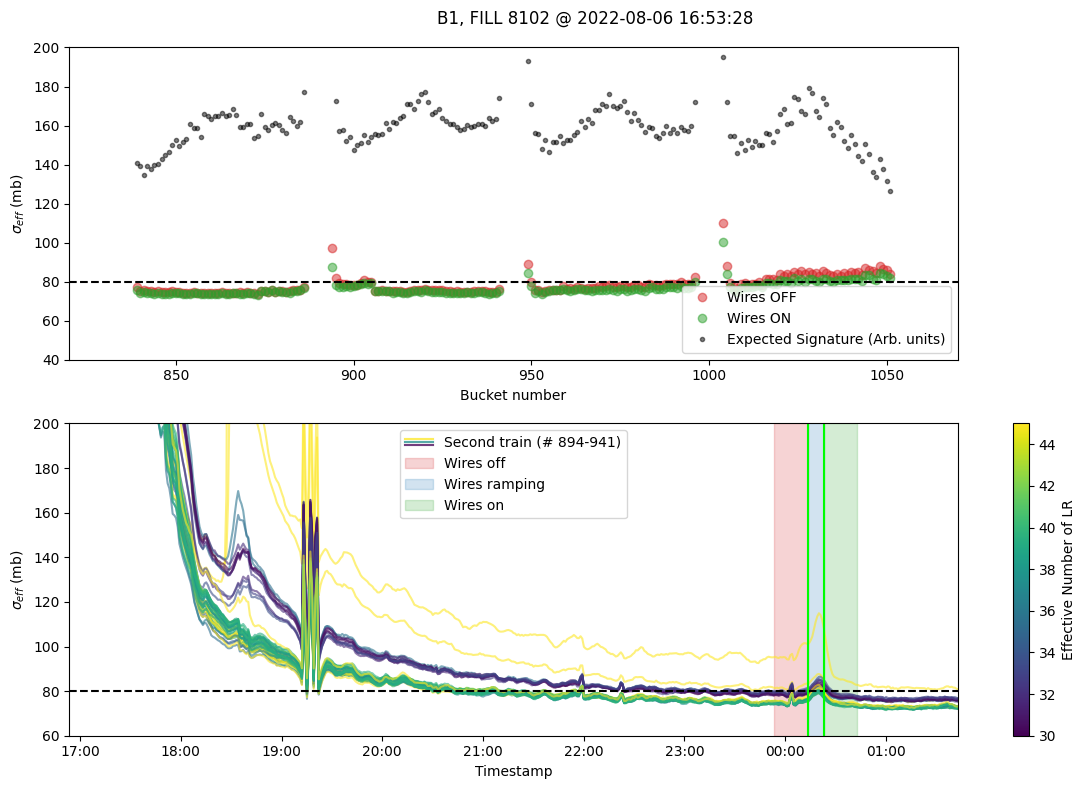

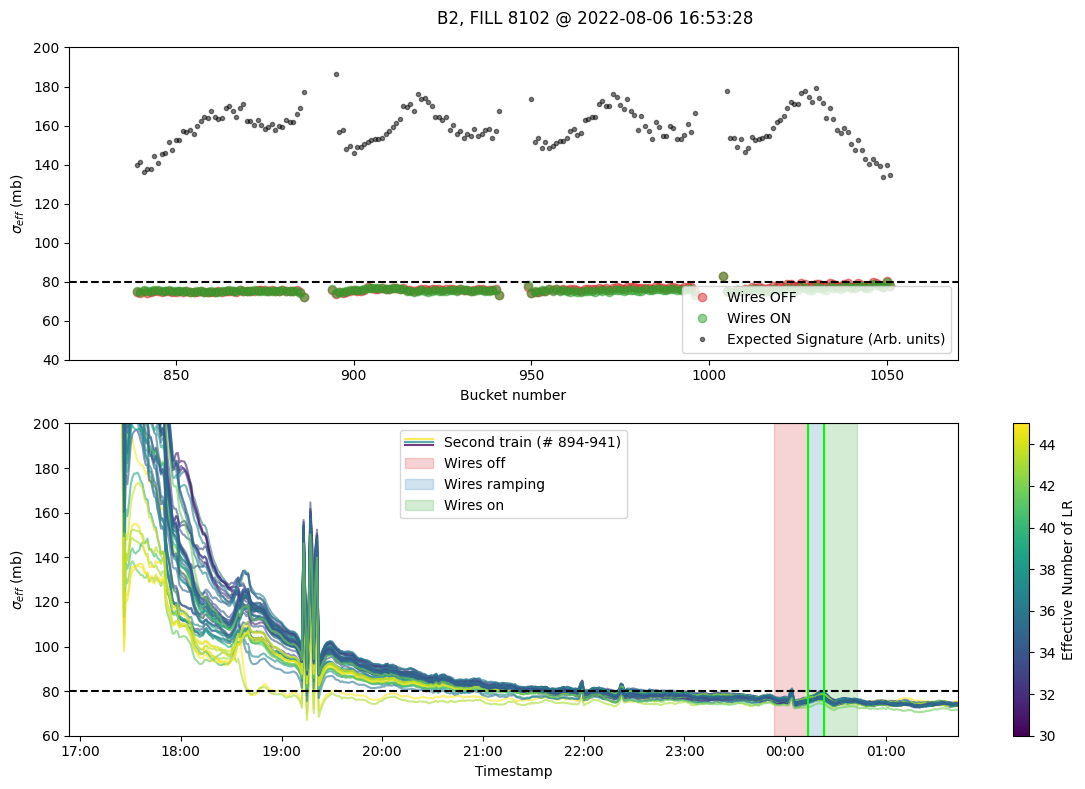

In [6]:


t0 = wire_start - pd.Timedelta(minutes=20)
t1 = wire_start
t2 = wire_stop
t3 = t2 + (t1-t0)


if FILL == 8102:
    t0 = wire_start - pd.Timedelta(minutes=20)
    t1 = wire_start
    t2 = wire_stop
    t3 = t2 + (t1-t0)
    time_window = [t0-pd.Timedelta(hours=7),t3+pd.Timedelta(minutes=60)]
    choosen_bunches = [820,1070]

if FILL == 8120:
    t0 = wire_start - pd.Timedelta(minutes=15)
    t1 = wire_start
    t2 = wire_stop
    t3 = t2 + (t1-t0)
    time_window     = [t0-pd.Timedelta(hours=1.25),t3+pd.Timedelta(minutes=60)]
    choosen_bunches = [700,1000]

if FILL == 8128:
    t0 = wire_start - pd.Timedelta(minutes=4)
    t1 = wire_start
    t2 = wire_stop
    t3 = t2 + (t1-t0)
    time_window     = [t0-pd.Timedelta(hours=0.5),t3+pd.Timedelta(minutes=60)]
    choosen_bunches = [700,1000]

if FILL == 8124:
    t0 = wire_start - pd.Timedelta(minutes=13)
    t1 = wire_start
    t2 = wire_stop
    t3 = t2 + (t1-t0)
    time_window     = [t0-pd.Timedelta(hours=0.75),t3+pd.Timedelta(minutes=60)]
    choosen_bunches = [700,1000]






for beam,bb_df in zip(beams,[patt.b1.bb_schedule,patt.b2.bb_schedule]):

    # COMPUTING BBLR
    #====================================================
    _N1    = bb_parameters.set_index('Timestamp')[f'bb_Intensity_avg_{beam.name}'].loc[t0:t1].mean()
    _epsx1 = bb_parameters.set_index('Timestamp')[f'bb_Emittance_H_{beam.name}'].loc[t0:t1].mean()
    _epsy1 = bb_parameters.set_index('Timestamp')[f'bb_Emittance_V_{beam.name}'].loc[t0:t1].mean()

    partner_beam = {'B1':beams[1],'B2':beams[0]}[beam.name]
    _N2    = bb_parameters.set_index('Timestamp')[f'bb_Intensity_avg_{partner_beam.name}'].loc[t0:t1].mean()
    _epsx2 = bb_parameters.set_index('Timestamp')[f'bb_Emittance_H_{partner_beam.name}'].loc[t0:t1].mean()
    _epsy2 = bb_parameters.set_index('Timestamp')[f'bb_Emittance_V_{partner_beam.name}'].loc[t0:t1].mean()


    Eff_LR       = np.nan*np.ones(len(buckets))
    BB_signature = np.nan*np.ones(len(buckets))
    study_bunches = bb_df.index[(bb_df.index>choosen_bunches[0])&(bb_df.index<choosen_bunches[1])]
    for bunch in study_bunches:
        partner_bunches = bb_df['BB partners in ATLAS/CMS'].loc[bunch]

        lumi_prop = (_epsx1[bunch]*_epsy1[bunch]*_epsx2[bunch]*_epsy2[bunch])**(1/4)/(_N1[bunch]*_N2[bunch])

        IP1_prop = 0.5*np.sum(_N2[list(partner_bunches.astype(int))]/_epsy2[list(partner_bunches.astype(int))])
        IP5_prop = 0.5*np.sum(_N2[list(partner_bunches.astype(int))]/_epsx2[list(partner_bunches.astype(int))])
        losses_prop = _N1[bunch]*(IP1_prop+IP5_prop)

        BB_signature[bunch] =  (losses_prop) * lumi_prop
        Eff_LR[bunch]       = losses_prop/(_N1[bunch]*_N2[bunch])*np.sqrt(_epsx1[bunch]*_epsy1[bunch])

    #BB_signature = BB_signature/np.max(BB_signature[~np.isnan(BB_signature)])
    #====================================================


    # COLORCODED
    #===============================

    TrainOI       = bb_df.loc[choosen_bunches[0]:]['Train'].iloc[0+50*1]
    study_bunches = bb_df.groupby('Train').get_group(TrainOI).index


    sc_label = f'Effective Number of LR'
    _colorby = Eff_LR
    vmin = 30#np.mean(cgrid)-1*np.std(cgrid)
    vmax = 45#np.mean(cgrid)+1*np.std(cgrid)
    #===============================

    fig, axes = plt.subplots(figsize=(12,8),ncols=1, nrows=2,gridspec_kw={'height_ratios': [1, 1]})
    
    plt.sca(axes[0])
    ROI_Before = xsection_df[beam.name].set_index('Timestamp').loc[ t0:t1]
    ROI_After  = xsection_df[beam.name].set_index('Timestamp').loc[ t2:t3]

    plt.plot(buckets,ROI_Before['sig_eff'].mean()/1e-3,'o',color='C3',alpha=0.5)
    plt.plot(buckets,ROI_After['sig_eff'].mean()/1e-3,'o',color='C2',alpha=0.5)

    #Dummy colorbar for figure
    sc = plt.scatter(buckets,np.nan*BB_signature,c = _colorby,vmin=vmin,vmax=vmax,cmap='viridis')
    cbar = plt.colorbar()
    cbar.set_label(sc_label)
    cbar.ax.set_visible(False)

    # Manual legend
    plt.plot([np.nan],[np.nan],'o',color='C3',alpha=0.5,label = 'Wires OFF')
    plt.plot([np.nan],[np.nan],'o',color='C2',alpha=0.5,label = 'Wires ON')
    plt.plot([np.nan],[np.nan],'.',color='k',alpha=0.5,label = 'Expected Signature (Arb. units)')
    plt.legend(loc='lower right')

    plt.axhline(80,ls='--',color='k')
    plt.ylim([40,200])
    plt.xlim(choosen_bunches)
    plt.xlabel('Bucket number')
    plt.ylabel(r'$\sigma_{eff}$ (mb)')

    # ADDING  LR PATTERN IN BACKGROUND
    #==================================
    plt.gca().set_frame_on(False)
    ax2 = plt.gca().twinx()
    ax2.set_zorder(-1)
    ax2.get_yaxis().set_visible(False)


    plt.plot(buckets,10+BB_signature,'.k',alpha=0.5,zorder=-10)
    plt.ylim([-20,70])
    #plt.plot(buckets[middles],LRcount[middles],'o',color='C1',alpha=0.8,zorder=-8)
    #plt.ylabel(r'Number of LR')
    #==================================


    plt.sca(axes[1])
    

    for tagged,info,color in zip([study_bunches],['nothing'],['C1']):    
        for bunch in tagged:

            ts       = xsection_df[beam.name]['Timestamp']
            xsection = xsection_df[beam.name]['sig_eff'].apply(lambda line:line[bunch])
            lifetime = xsection_df[beam.name]['Lifetime'].apply(lambda line:line[bunch])

            ts_smooth       = xsection_smooth_df[beam.name]['Timestamp']
            xsection_smooth = xsection_smooth_df[beam.name]['sig_eff'].apply(lambda line:line[bunch])
            lifetime_smooth     = xsection_smooth_df[beam.name]['Lifetime'].apply(lambda line:line[bunch])

            #plt.plot(ts       ,xsection/1e-3       ,'.',alpha=0.2,color=color)
            #plt.plot(ts_smooth,xsection_smooth/1e-3,'-',alpha=0.5,color=color)

            # Creating color distribution with scatter
            
            sc = plt.scatter(buckets,np.nan*BB_signature,c = _colorby,vmin=vmin,vmax=vmax,cmap='viridis')

            # Plotting smotthed lines
            plt.plot(ts_smooth, xsection_smooth/1e-3,'-',alpha=0.6,color=sc.to_rgba(_colorby[bunch]))


    cbar = plt.colorbar()
    cbar.set_label(sc_label)

    plt.axhline(80,ls='--',color='k')
    plt.axvline(wire_start,color='lime')
    plt.axvline(wire_stop,color='lime')
    plt.fill_between([t0,t1], 0, 1, color='C3', alpha=0.2, transform=plt.gca().get_xaxis_transform(),label = 'Wires off')
    plt.fill_between([t1,t2], 0, 1, color='C0', alpha=0.2, transform=plt.gca().get_xaxis_transform(),label = 'Wires ramping')
    plt.fill_between([t2,t3], 0, 1, color='C2', alpha=0.2, transform=plt.gca().get_xaxis_transform(),label = 'Wires on')

    plt.ylim([60,200])
    plt.xlim(time_window)
    plt.ylabel(r'$\sigma_{eff}$ (mb)')
    plt.xlabel(r'Timestamp')

    # ADJUSTING LEGEND
    #====================================
    plt.legend()
    handles, labels = plt.gca().get_legend_handles_labels()
    line0, = plt.plot([np.nan],[np.nan],'-',alpha=0.5,color=sc.to_rgba(vmax))
    line1, = plt.plot([np.nan],[np.nan],'-',alpha=0.5,color=sc.to_rgba(np.mean([vmin,vmax])))
    line2, = plt.plot([np.nan],[np.nan],'-',alpha=0.5,color=sc.to_rgba(vmin))

    plt.legend([(line0,line1, line2)]+handles, 
                [f'Second train (# {study_bunches[0]}-{study_bunches[-1]})']+labels,
                handler_map = {tuple : HandlerTupleVertical()})
    #====================================

    plt.suptitle(f'{beam.name}, FILL {FILL} @ {str(time_window[0])[:19]}')
    plt.tight_layout()
    
    #plt.savefig(f'../Results_Lumi_V2/Presentations/AVG_F{FILL}_{beam.name}.png',dpi=300)
    plt.savefig(f'../Results_Lumi_V2/Uppsala/colored_BBexpected_F{FILL}_{beam.name}.png',dpi=300)



In [7]:
sys.exit(0)

SystemExit: 0

/home/phbelang/abp/WireDAQ/py_wireDAQ/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


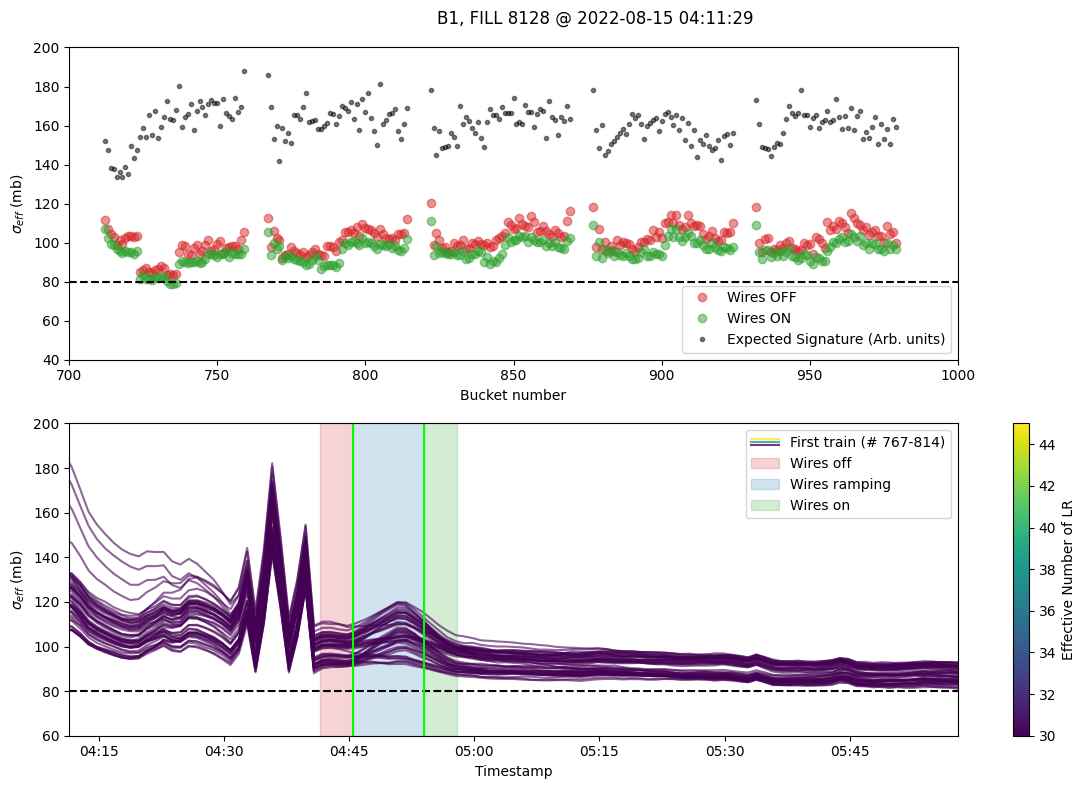

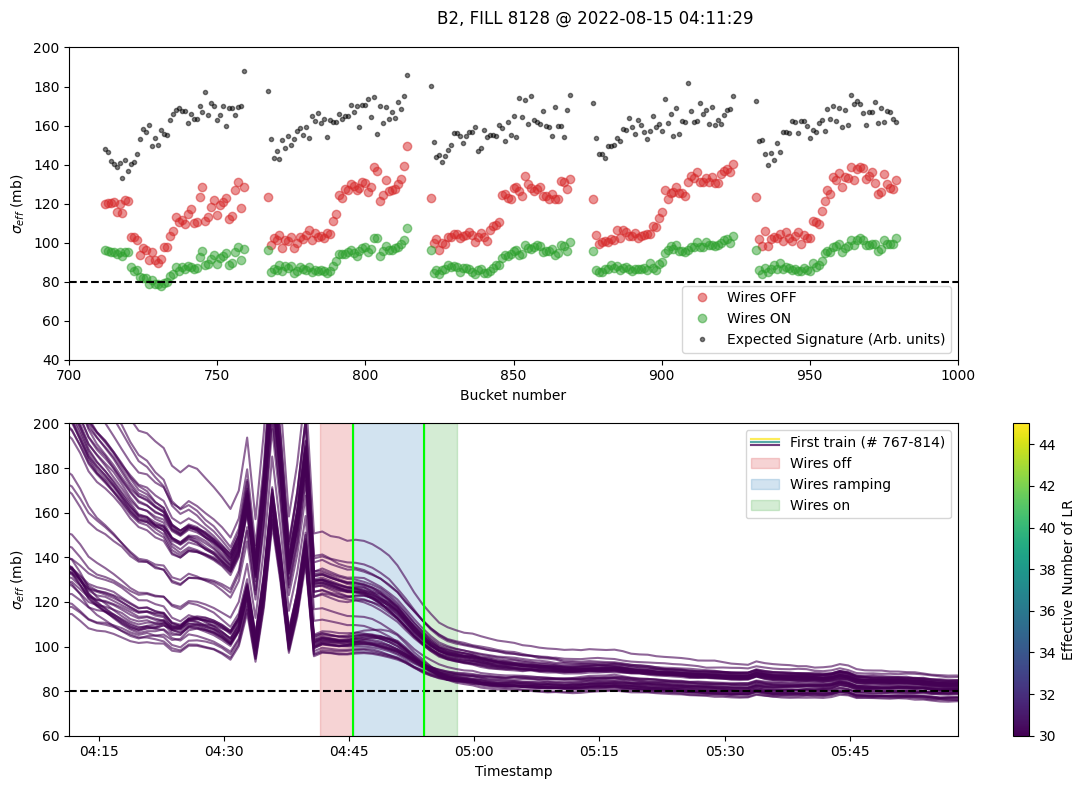

In [ ]:


t0 = wire_start - pd.Timedelta(minutes=20)
t1 = wire_start
t2 = wire_stop
t3 = t2 + (t1-t0)


if FILL == 8102:
    t0 = wire_start - pd.Timedelta(minutes=20)
    t1 = wire_start
    t2 = wire_stop
    t3 = t2 + (t1-t0)
    time_window = [t0-pd.Timedelta(hours=7),t3+pd.Timedelta(minutes=60)]
    choosen_bunches = [820,1070]

if FILL == 8120:
    t0 = wire_start - pd.Timedelta(minutes=15)
    t1 = wire_start
    t2 = wire_stop
    t3 = t2 + (t1-t0)
    time_window     = [t0-pd.Timedelta(hours=1.25),t3+pd.Timedelta(minutes=60)]
    choosen_bunches = [700,1000]

if FILL == 8128:
    t0 = wire_start - pd.Timedelta(minutes=4)
    t1 = wire_start
    t2 = wire_stop
    t3 = t2 + (t1-t0)
    time_window     = [t0-pd.Timedelta(hours=0.5),t3+pd.Timedelta(minutes=60)]
    choosen_bunches = [700,1000]

if FILL == 8124:
    t0 = wire_start - pd.Timedelta(minutes=13)
    t1 = wire_start
    t2 = wire_stop
    t3 = t2 + (t1-t0)
    time_window     = [t0-pd.Timedelta(hours=0.75),t3+pd.Timedelta(minutes=60)]
    choosen_bunches = [700,1000]






for beam,bb_df in zip(beams,[patt.b1.bb_schedule,patt.b2.bb_schedule]):

    # COMPUTING BBLR
    #====================================================
    _N1    = bb_parameters.set_index('Timestamp')[f'bb_Intensity_avg_{beam.name}'].loc[t0:t1].mean()
    _epsx1 = bb_parameters.set_index('Timestamp')[f'bb_Emittance_H_{beam.name}'].loc[t0:t1].mean()
    _epsy1 = bb_parameters.set_index('Timestamp')[f'bb_Emittance_V_{beam.name}'].loc[t0:t1].mean()

    partner_beam = {'B1':beams[1],'B2':beams[0]}[beam.name]
    _N2    = bb_parameters.set_index('Timestamp')[f'bb_Intensity_avg_{partner_beam.name}'].loc[t0:t1].mean()
    _epsx2 = bb_parameters.set_index('Timestamp')[f'bb_Emittance_H_{partner_beam.name}'].loc[t0:t1].mean()
    _epsy2 = bb_parameters.set_index('Timestamp')[f'bb_Emittance_V_{partner_beam.name}'].loc[t0:t1].mean()


    BB_signature = np.nan*np.ones(len(buckets))
    BB_signature = np.nan*np.ones(len(buckets))
    study_bunches = bb_df.index[(bb_df.index>choosen_bunches[0])&(bb_df.index<choosen_bunches[1])]
    for bunch in study_bunches:
        partner_bunches = bb_df['BB partners in ATLAS/CMS'].loc[bunch]

        #lumi_prop = (_epsx1[bunch]*_epsy1[bunch]*_epsx2[bunch]*_epsy2[bunch])**(1/4)/(_N1[bunch]*_N2[bunch])

        #IP1_prop = 0.5*np.sum(_N2[list(partner_bunches.astype(int))]/_epsy2[list(partner_bunches.astype(int))])
        #IP5_prop = 0.5*np.sum(_N2[list(partner_bunches.astype(int))]/_epsx2[list(partner_bunches.astype(int))])
        #losses_prop = _N1[bunch]*(IP1_prop+IP5_prop)

        #BB_signature[bunch] =  np.sqrt(_epsx1[bunch]*_epsy1[bunch])#(losses_prop) * lumi_prop
        BB_signature[bunch] =  np.sqrt(_epsx1[bunch]*_epsy1[bunch])/_N1[bunch]#_epsx1[bunch]

    BB_signature = BB_signature/np.max(BB_signature[~np.isnan(BB_signature)])
    #====================================================


    # COLORCODED
    #===============================

    TrainOI       = bb_df.loc[choosen_bunches[0]:]['Train'].iloc[0+50*1]
    study_bunches = bb_df.groupby('Train').get_group(TrainOI).index


    sc_label = f'Effective Number of LR'
    _colorby = BB_signature
    vmin = 30#np.mean(cgrid)-1*np.std(cgrid)
    vmax = 45#np.mean(cgrid)+1*np.std(cgrid)
    #===============================

    fig, axes = plt.subplots(figsize=(12,8),ncols=1, nrows=2,gridspec_kw={'height_ratios': [1, 1]})
    
    plt.sca(axes[0])
    ROI_Before = xsection_df[beam.name].set_index('Timestamp').loc[ t0:t1]
    ROI_After  = xsection_df[beam.name].set_index('Timestamp').loc[ t2:t3]

    plt.plot(buckets,ROI_Before['sig_eff'].mean()/1e-3,'o',color='C3',alpha=0.5)
    plt.plot(buckets,ROI_After['sig_eff'].mean()/1e-3,'o',color='C2',alpha=0.5)

    #Dummy colorbar for figure
    sc = plt.scatter(buckets,np.nan*BB_signature,c = _colorby,vmin=vmin,vmax=vmax,cmap='viridis')
    cbar = plt.colorbar()
    cbar.set_label(sc_label)
    cbar.ax.set_visible(False)

    # Manual legend
    plt.plot([np.nan],[np.nan],'o',color='C3',alpha=0.5,label = 'Wires OFF')
    plt.plot([np.nan],[np.nan],'o',color='C2',alpha=0.5,label = 'Wires ON')
    plt.plot([np.nan],[np.nan],'.',color='k',alpha=0.5,label = 'Expected Signature (Arb. units)')
    plt.legend(loc='lower right')

    plt.axhline(80,ls='--',color='k')
    plt.ylim([40,200])
    plt.xlim(choosen_bunches)
    plt.xlabel('Bucket number')
    plt.ylabel(r'$\sigma_{eff}$ (mb)')

    # ADDING  LR PATTERN IN BACKGROUND
    #==================================
    plt.gca().set_frame_on(False)
    ax2 = plt.gca().twinx()
    ax2.set_zorder(-1)
    ax2.get_yaxis().set_visible(False)


    plt.plot(buckets,BB_signature,'.k',alpha=0.5,zorder=-10)
    plt.ylim([-0.25,1.1])
    #plt.plot(buckets[middles],LRcount[middles],'o',color='C1',alpha=0.8,zorder=-8)
    #plt.ylabel(r'Number of LR')
    #==================================


    plt.sca(axes[1])
    

    for tagged,info,color in zip([study_bunches],['nothing'],['C1']):    
        for bunch in tagged:

            ts       = xsection_df[beam.name]['Timestamp']
            xsection = xsection_df[beam.name]['sig_eff'].apply(lambda line:line[bunch])
            lifetime = xsection_df[beam.name]['Lifetime'].apply(lambda line:line[bunch])

            ts_smooth       = xsection_smooth_df[beam.name]['Timestamp']
            xsection_smooth = xsection_smooth_df[beam.name]['sig_eff'].apply(lambda line:line[bunch])
            lifetime_smooth     = xsection_smooth_df[beam.name]['Lifetime'].apply(lambda line:line[bunch])

            #plt.plot(ts       ,xsection/1e-3       ,'.',alpha=0.2,color=color)
            #plt.plot(ts_smooth,xsection_smooth/1e-3,'-',alpha=0.5,color=color)

            # Creating color distribution with scatter
            
            sc = plt.scatter(buckets,np.nan*BB_signature,c = _colorby,vmin=vmin,vmax=vmax,cmap='viridis')

            # Plotting smotthed lines
            plt.plot(ts_smooth, xsection_smooth/1e-3,'-',alpha=0.6,color=sc.to_rgba(_colorby[bunch]))


    cbar = plt.colorbar()
    cbar.set_label(sc_label)

    plt.axhline(80,ls='--',color='k')
    plt.axvline(wire_start,color='lime')
    plt.axvline(wire_stop,color='lime')
    plt.fill_between([t0,t1], 0, 1, color='C3', alpha=0.2, transform=plt.gca().get_xaxis_transform(),label = 'Wires off')
    plt.fill_between([t1,t2], 0, 1, color='C0', alpha=0.2, transform=plt.gca().get_xaxis_transform(),label = 'Wires ramping')
    plt.fill_between([t2,t3], 0, 1, color='C2', alpha=0.2, transform=plt.gca().get_xaxis_transform(),label = 'Wires on')

    plt.ylim([60,200])
    plt.xlim(time_window)
    plt.ylabel(r'$\sigma_{eff}$ (mb)')
    plt.xlabel(r'Timestamp')

    # ADJUSTING LEGEND
    #====================================
    plt.legend()
    handles, labels = plt.gca().get_legend_handles_labels()
    line0, = plt.plot([np.nan],[np.nan],'-',alpha=0.5,color=sc.to_rgba(vmax))
    line1, = plt.plot([np.nan],[np.nan],'-',alpha=0.5,color=sc.to_rgba(np.mean([vmin,vmax])))
    line2, = plt.plot([np.nan],[np.nan],'-',alpha=0.5,color=sc.to_rgba(vmin))

    plt.legend([(line0,line1, line2)]+handles, 
                [f'First train (# {study_bunches[0]}-{study_bunches[-1]})']+labels,
                handler_map = {tuple : HandlerTupleVertical()})
    #====================================

    plt.suptitle(f'{beam.name}, FILL {FILL} @ {str(time_window[0])[:19]}')
    plt.tight_layout()
    
    #plt.savefig(f'../Results_Lumi_V2/Presentations/AVG_F{FILL}_{beam.name}.png',dpi=300)
    #plt.savefig(f'../Results_Lumi_V2/Presentations/colored_Intensity_F{FILL}_{beam.name}.png',dpi=300)



In [ ]:
TrainOI       = bb_df.loc[choosen_bunches[0]:]['Train'].iloc[1]
    study_bunches = bb_df.groupby('Train').get_group(TrainOI).index

Int64Index([712, 713, 714, 715, 716, 717, 718, 719, 720, 721, 722, 723, 724,
            725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 737,
            738, 739, 740, 741, 742, 743, 744, 745, 746, 747, 748, 749, 750,
            751, 752, 753, 754, 755, 756, 757, 758, 759],
           dtype='int64')

In [ ]:
patt.b2.bb_schedule.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            3344, 3345, 3346, 3347, 3348, 3349, 3350, 3351, 3352, 3353],
           dtype='int64', length=2413)

In [ ]:
patt.b1.bb_schedule.index

Int64Index([  12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
            ...
            3344, 3345, 3346, 3347, 3348, 3349, 3350, 3351, 3352, 3353],
           dtype='int64', length=2413)

In [ ]:
patt.b1.bb_schedule['BB partners in ATLAS/CMS'].loc[12]

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

Text(0.5, 0, 'Bunch number')

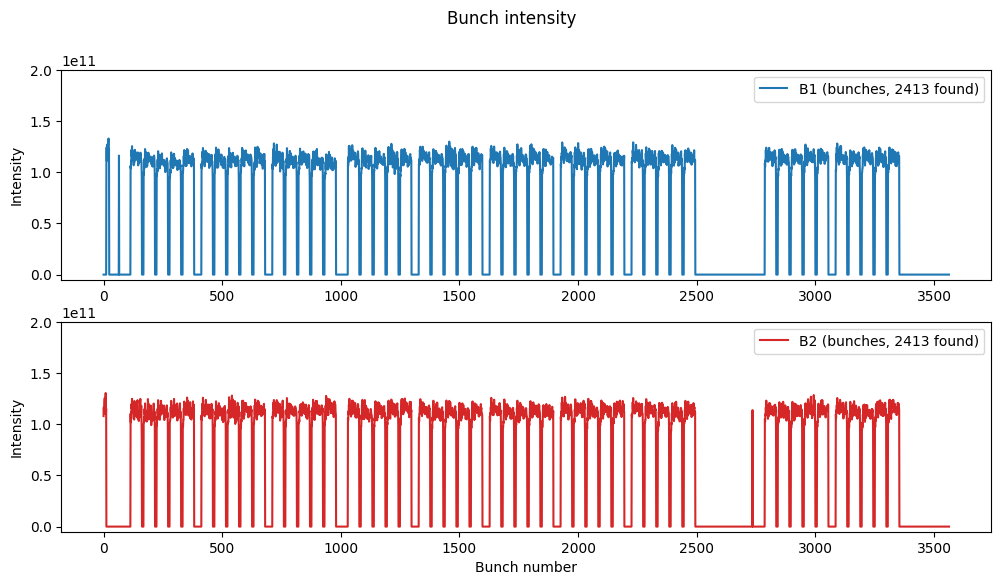

In [ ]:

fig, axes = plt.subplots(figsize= (FIGWIDTH,6),ncols=1, nrows=2,gridspec_kw={'height_ratios': [1, 1]})
for beam,bb_df,ax,color in zip(beams,[patt.b1.bb_schedule,patt.b2.bb_schedule],axes,['C0','C3']):

 
    bunch_I= database.at_ts(start_ts ,beam['bb_Intensity'],method='nearest',return_ts=False)

    Nb_found = np.sum(bunch_I>0.5e11)

    plt.sca(ax)
    plt.plot(bunch_I,color=color,label = f'{beam.name} (bunches, {Nb_found} found)')
    

    firsts  =  bb_df.groupby('Tag').get_group('first').index
    middles =  bb_df.groupby('Tag').get_group('middle').index



    plt.legend()
    plt.ylim([-0.05e11,2e11])
    plt.ylabel('Intensity')
fig.suptitle('Bunch intensity')
plt.xlabel('Bunch number')

In [ ]:
(_epsx1[bunch]*_epsy1[bunch]*_epsx2[bunch]*_epsy2[bunch])**(1/4)

1.435776810117614

In [ ]:
study_bunches = bb_df.index[(bb_df.index>choosen_bunches[0])&(bb_df.index<choosen_bunches[1])]
study_bunches

Int64Index([712, 713, 714, 715, 716, 717, 718, 719, 720, 721,
            ...
            970, 971, 972, 973, 974, 975, 976, 977, 978, 979],
           dtype='int64', length=240)

In [ ]:
 _epsx1 = bb_parameters.set_index('Timestamp')[f'bb_Emittance_H_{beam.name}'].loc[t0:t1].mean()

In [ ]:
    _N1    = bb_parameters.set_index('Timestamp')[f'bb_Intensity_avg_{beam.name}'].loc[t0:t1].mean()
    _epsx1 = bb_parameters.set_index('Timestamp')[f'bb_Emittance_H_{beam.name}'].loc[t0:t1].mean()
    _epsy1 = bb_parameters.set_index('Timestamp')[f'bb_Emittance_V_{beam.name}'].loc[t0:t1].mean()

    partner_beam = {'B1':beams[1],'B2':beams[0]}[beam.name]
    _N2    = bb_parameters.set_index('Timestamp')[f'bb_Intensity_avg_{partner_beam.name}'].loc[t0:t1].mean()
    _epsx2 = bb_parameters.set_index('Timestamp')[f'bb_Emittance_H_{partner_beam.name}'].loc[t0:t1].mean()
    _epsy2 = bb_parameters.set_index('Timestamp')[f'bb_Emittance_V_{partner_beam.name}'].loc[t0:t1].mean()


In [ ]:
partner_bunches

array([712., 713., 714., 715., 716., 717., 718., 719., 720., 721., 722.,
       723., 724., 725., 726., 727., 728., 729., 730., 731., 732., 733.])

In [ ]:
len(partner_bunches)

22

In [ ]:
partner_beam.name

'B1'

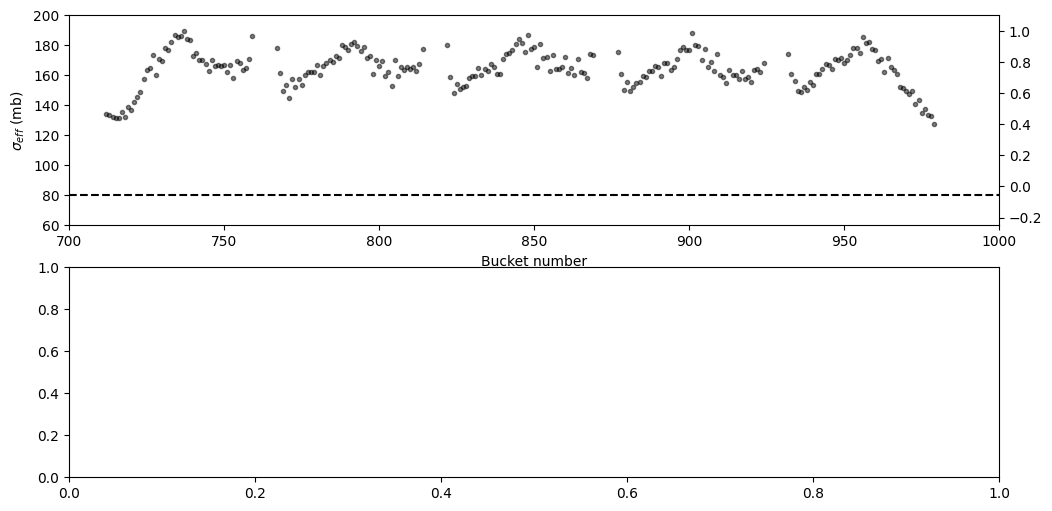

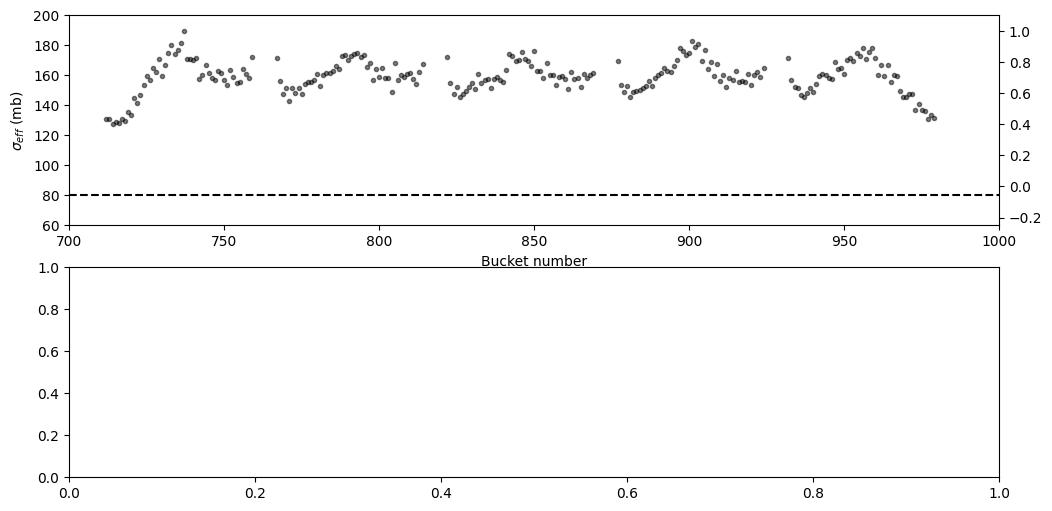

In [ ]:

if FILL == 8102:
    t0 = wire_start - pd.Timedelta(minutes=20)
    t1 = wire_start
    t2 = wire_stop
    t3 = t2 + (t1-t0)
    time_window = [t0-pd.Timedelta(hours=7),t3+pd.Timedelta(minutes=60)]
    choosen_bunches = [820,1070]

if FILL == 8120:
    t0 = wire_start - pd.Timedelta(minutes=15)
    t1 = wire_start
    t2 = wire_stop
    t3 = t2 + (t1-t0)
    time_window     = [t0-pd.Timedelta(hours=1.25),t3+pd.Timedelta(minutes=60)]
    choosen_bunches = [700,1000]

if FILL == 8128:
    t0 = wire_start - pd.Timedelta(minutes=4)
    t1 = wire_start
    t2 = wire_stop
    t3 = t2 + (t1-t0)
    time_window     = [t0-pd.Timedelta(hours=0.5),t3+pd.Timedelta(minutes=60)]
    choosen_bunches = [700,1000]

if FILL == 8124:
    t0 = wire_start - pd.Timedelta(minutes=13)
    t1 = wire_start
    t2 = wire_stop
    t3 = t2 + (t1-t0)
    time_window     = [t0-pd.Timedelta(hours=0.75),t3+pd.Timedelta(minutes=60)]
    choosen_bunches = [700,1000]



for beam,bb_df in zip(beams,[patt.b1.bb_schedule,patt.b2.bb_schedule]):

    # Identifyin the bunches
    #TrainOI       = bb_df.loc[choosen_bunches[0]:]['Train'].iloc[0]
    #study_bunches = bb_df.groupby('Train').get_group(TrainOI).index


    # COLORCODED
    #===============================

    _N1    = bb_parameters.set_index('Timestamp')[f'bb_Intensity_avg_{beam.name}'].loc[t0:t1].mean()
    _epsx1 = bb_parameters.set_index('Timestamp')[f'bb_Emittance_H_{beam.name}'].loc[t0:t1].mean()
    _epsy1 = bb_parameters.set_index('Timestamp')[f'bb_Emittance_V_{beam.name}'].loc[t0:t1].mean()

    partner_beam = {'B1':beams[1],'B2':beams[0]}[beam.name]
    _N2    = bb_parameters.set_index('Timestamp')[f'bb_Intensity_avg_{partner_beam.name}'].loc[t0:t1].mean()
    _epsx2 = bb_parameters.set_index('Timestamp')[f'bb_Emittance_H_{partner_beam.name}'].loc[t0:t1].mean()
    _epsy2 = bb_parameters.set_index('Timestamp')[f'bb_Emittance_V_{partner_beam.name}'].loc[t0:t1].mean()

    if False:
        _N1    = 1.1e11+0*bb_parameters.set_index('Timestamp')[f'bb_Intensity_avg_{beam.name}'].loc[t0:t1].mean()
        _epsx1 = 2.5+0*bb_parameters.set_index('Timestamp')[f'bb_Emittance_H_{beam.name}'].loc[t0:t1].mean()
        _epsy1 = 2.5+0*bb_parameters.set_index('Timestamp')[f'bb_Emittance_V_{beam.name}'].loc[t0:t1].mean()

        partner_beam = {'B1':beams[1],'B2':beams[0]}[beam.name]
        _N2    = 1.1e11+0*bb_parameters.set_index('Timestamp')[f'bb_Intensity_avg_{partner_beam.name}'].loc[t0:t1].mean()
        _epsx2 = 2.5+0*bb_parameters.set_index('Timestamp')[f'bb_Emittance_H_{partner_beam.name}'].loc[t0:t1].mean()
        _epsy2 = 2.5+0*bb_parameters.set_index('Timestamp')[f'bb_Emittance_V_{partner_beam.name}'].loc[t0:t1].mean()


    fig, axes = plt.subplots(figsize=(12,6),ncols=1, nrows=2,gridspec_kw={'height_ratios': [1, 1]})
    
    plt.sca(axes[0])

    plt.axhline(80,ls='--',color='k')
    plt.ylim([60,200])
    plt.xlim(choosen_bunches)
    plt.xlabel('Bucket number')
    plt.ylabel(r'$\sigma_{eff}$ (mb)')

    # ADDING  LR PATTERN IN BACKGROUND
    #==================================
    plt.gca().set_frame_on(False)
    ax2 = plt.gca().twinx()
    ax2.set_zorder(-1)
    #ax2.get_yaxis().set_visible(False)

    BB_signature = np.nan*np.ones(len(buckets))
    study_bunches = bb_df.index[(bb_df.index>choosen_bunches[0])&(bb_df.index<choosen_bunches[1])]
    for bunch in study_bunches:
        partner_bunches = bb_df['BB partners in ATLAS/CMS'].loc[bunch]

        lumi_prop = (_epsx1[bunch]*_epsy1[bunch]*_epsx2[bunch]*_epsy2[bunch])**(1/4)/(_N1[bunch]*_N2[bunch])

        IP1_prop = 0.5*np.sum(_N2[list(partner_bunches.astype(int))]/_epsy2[list(partner_bunches.astype(int))])
        IP5_prop = 0.5*np.sum(_N2[list(partner_bunches.astype(int))]/_epsx2[list(partner_bunches.astype(int))])
        losses_prop = _N1[bunch]*(IP1_prop+IP5_prop)

        BB_signature[bunch] =  (losses_prop) * lumi_prop


    plt.plot(buckets,BB_signature/np.max(BB_signature[~np.isnan(BB_signature)]),'.k',alpha=0.5,zorder=-10)
    plt.ylim([-0.25,1.1])
    #plt.plot(buckets[middles],LRcount[middles],'o',color='C1',alpha=0.8,zorder=-8)
    #plt.ylabel(r'Number of LR')
    #==================================

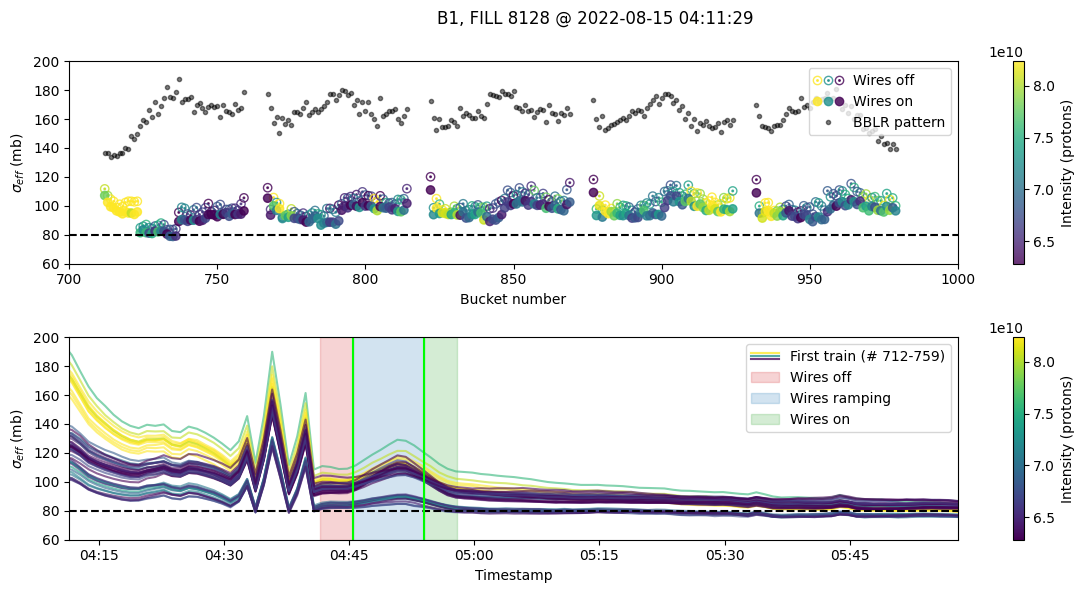

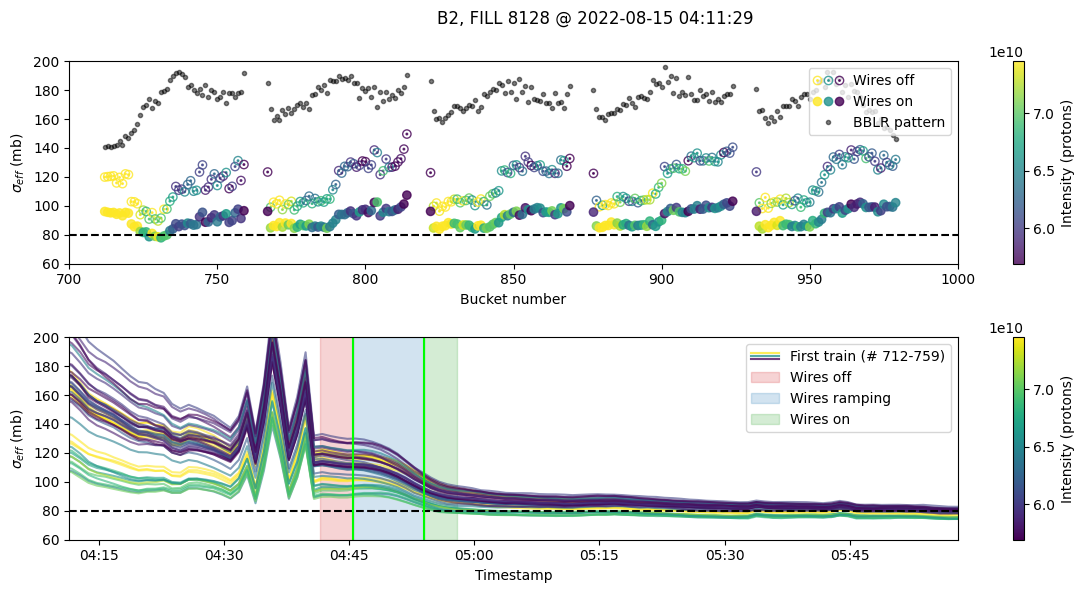

In [ ]:


t0 = wire_start - pd.Timedelta(minutes=20)
t1 = wire_start
t2 = wire_stop
t3 = t2 + (t1-t0)


if FILL == 8102:
    t0 = wire_start - pd.Timedelta(minutes=20)
    t1 = wire_start
    t2 = wire_stop
    t3 = t2 + (t1-t0)
    time_window = [t0-pd.Timedelta(hours=7),t3+pd.Timedelta(minutes=60)]
    choosen_bunches = [820,1070]

if FILL == 8120:
    t0 = wire_start - pd.Timedelta(minutes=15)
    t1 = wire_start
    t2 = wire_stop
    t3 = t2 + (t1-t0)
    time_window     = [t0-pd.Timedelta(hours=1.25),t3+pd.Timedelta(minutes=60)]
    choosen_bunches = [700,1000]

if FILL == 8128:
    t0 = wire_start - pd.Timedelta(minutes=4)
    t1 = wire_start
    t2 = wire_stop
    t3 = t2 + (t1-t0)
    time_window     = [t0-pd.Timedelta(hours=0.5),t3+pd.Timedelta(minutes=60)]
    choosen_bunches = [700,1000]

if FILL == 8124:
    t0 = wire_start - pd.Timedelta(minutes=13)
    t1 = wire_start
    t2 = wire_stop
    t3 = t2 + (t1-t0)
    time_window     = [t0-pd.Timedelta(hours=0.75),t3+pd.Timedelta(minutes=60)]
    choosen_bunches = [700,1000]






for beam,bb_df in zip(beams,[patt.b1.bb_schedule,patt.b2.bb_schedule]):

    # COLORCODED
    #===============================
    sc_label = f'Intensity (protons)'

    _N    = bb_parameters.set_index('Timestamp')[f'bb_Intensity_avg_{beam.name}']
    _epsx = bb_parameters.set_index('Timestamp')[f'bb_Emittance_H_{beam.name}']
    _epsy = bb_parameters.set_index('Timestamp')[f'bb_Emittance_V_{beam.name}']

    _N    = bb_parameters.set_index('Timestamp')[f'bb_Intensity_avg_{beam.name}']
    _epsx = bb_parameters.set_index('Timestamp')[f'bb_Emittance_H_{beam.name}']
    _epsy = bb_parameters.set_index('Timestamp')[f'bb_Emittance_V_{beam.name}']

    
    #_colorby = _N/(_epsx*_epsy)/1e10
    _colorby = 0.5*(_N/_epsx + _N/_epsy)

    #_colorby = bb_parameters.set_index('Timestamp')[f'bb_Intensity_avg_{beam.name}']
    # Figuring out colormap
    _,cgrid = _colorby[time_window[0]:time_window[1]].to_2D()
    cgrid = cgrid [:,bb_df.index]
    vmin = np.mean(cgrid)-1*np.std(cgrid)
    vmax = np.mean(cgrid)+1*np.std(cgrid)

    TrainOI       = bb_df.loc[choosen_bunches[0]:]['Train'].iloc[0]
    study_bunches = bb_df.groupby('Train').get_group(TrainOI).index
    #===============================

    fig, axes = plt.subplots(figsize=(12,6),ncols=1, nrows=2,gridspec_kw={'height_ratios': [1, 1]})
    
    plt.sca(axes[0])
    ROI_Before = xsection_df[beam.name].set_index('Timestamp').loc[ t0:t1]
    ROI_After  = xsection_df[beam.name].set_index('Timestamp').loc[ t2:t3]

    
    # Before
    sc_alpha = 0.8
    sc = plt.scatter(buckets,ROI_Before['sig_eff'].mean()/1e-3, marker='.',s=5 ,c = _colorby[t2:t3].mean(),vmin=vmin,vmax=vmax,alpha=sc_alpha,cmap='viridis')
    plt.scatter(buckets,ROI_Before['sig_eff'].mean()/1e-3, facecolors='none',edgecolors=sc.to_rgba(_colorby[t2:t3].mean()),vmin=vmin,vmax=vmax,alpha=sc_alpha,cmap='viridis')
    # After
    plt.scatter(buckets,ROI_After['sig_eff'].mean()/1e-3 ,c = _colorby[t0:t1].mean(),vmin=vmin,vmax=vmax,alpha=sc_alpha,cmap='viridis')
    
    cbar = plt.colorbar()
    cbar.set_label(sc_label)

    # LEGEND
    #================================
    make_fun_legend()

    #================================


    plt.axhline(80,ls='--',color='k')
    plt.ylim([60,200])
    plt.xlim(choosen_bunches)
    plt.xlabel('Bucket number')
    plt.ylabel(r'$\sigma_{eff}$ (mb)')

    # ADDING  LR PATTERN IN BACKGROUND
    #==================================
    plt.gca().set_frame_on(False)
    ax2 = plt.gca().twinx()
    ax2.set_zorder(-1)
    ax2.get_yaxis().set_visible(False)
    LRcount = np.nan*np.zeros(len(buckets))
    LRcount[bb_df.index] = bb_df['# of LR in ATLAS/CMS']

    scaling = 1/(_colorby.loc[t0:t1].mean())

    BB_signature = LRcount*scaling
    BB_signature = BB_signature/np.max(BB_signature[~np.isnan(BB_signature)])

    plt.plot(buckets,BB_signature,'.k',alpha=0.5,zorder=-10)
    plt.ylim([-0.5,1])
    #plt.plot(buckets[middles],LRcount[middles],'o',color='C1',alpha=0.8,zorder=-8)
    #plt.ylabel(r'Number of LR')
    #==================================


    plt.sca(axes[1])
    

    for tagged,info,color in zip([study_bunches],['nothing'],['C1']):    
        for bunch in tagged:

            ts       = xsection_df[beam.name]['Timestamp']
            xsection = xsection_df[beam.name]['sig_eff'].apply(lambda line:line[bunch])
            lifetime = xsection_df[beam.name]['Lifetime'].apply(lambda line:line[bunch])

            ts_smooth       = xsection_smooth_df[beam.name]['Timestamp']
            xsection_smooth = xsection_smooth_df[beam.name]['sig_eff'].apply(lambda line:line[bunch])
            lifetime_smooth     = xsection_smooth_df[beam.name]['Lifetime'].apply(lambda line:line[bunch])

            #plt.plot(ts       ,xsection/1e-3       ,'.',alpha=0.2,color=color)
            #plt.plot(ts_smooth,xsection_smooth/1e-3,'-',alpha=0.5,color=color)

            # Creating color distribution with scatter
            bunch_color =  _colorby.apply(lambda line:line[bunch])
            sc = plt.scatter(ts_smooth ,np.nan*xsection_smooth,c = bunch_color ,vmin=vmin,vmax=vmax,cmap='viridis')

            # Plotting smotthed lines
            plt.plot(ts_smooth, xsection_smooth/1e-3,'-',alpha=0.6,color=sc.to_rgba(np.mean(bunch_color[time_window[0]:time_window[1]])))


    cbar = plt.colorbar()
    cbar.set_label(sc_label)

    plt.axhline(80,ls='--',color='k')
    plt.axvline(wire_start,color='lime')
    plt.axvline(wire_stop,color='lime')
    plt.fill_between([t0,t1], 0, 1, color='C3', alpha=0.2, transform=plt.gca().get_xaxis_transform(),label = 'Wires off')
    plt.fill_between([t1,t2], 0, 1, color='C0', alpha=0.2, transform=plt.gca().get_xaxis_transform(),label = 'Wires ramping')
    plt.fill_between([t2,t3], 0, 1, color='C2', alpha=0.2, transform=plt.gca().get_xaxis_transform(),label = 'Wires on')

    plt.ylim([60,200])
    plt.xlim(time_window)
    plt.ylabel(r'$\sigma_{eff}$ (mb)')
    plt.xlabel(r'Timestamp')

    # ADJUSTING LEGEND
    #====================================
    plt.legend()
    handles, labels = plt.gca().get_legend_handles_labels()
    line0, = plt.plot([np.nan],[np.nan],'-',alpha=0.5,color=sc.to_rgba(+np.inf))
    line1, = plt.plot([np.nan],[np.nan],'-',alpha=0.5,color=sc.to_rgba(np.mean(cgrid)))
    line2, = plt.plot([np.nan],[np.nan],'-',alpha=0.5,color=sc.to_rgba(-np.inf))

    plt.legend([(line0,line1, line2)]+handles, 
                [f'First train (# {study_bunches[0]}-{study_bunches[-1]})']+labels,
                handler_map = {tuple : HandlerTupleVertical()})
    #====================================

    plt.suptitle(f'{beam.name}, FILL {FILL} @ {str(time_window[0])[:19]}')
    plt.tight_layout()
    
    #plt.savefig(f'../Results_Lumi_V2/Presentations/AVG_F{FILL}_{beam.name}.png',dpi=300)
    #plt.savefig(f'../Results_Lumi_V2/Presentations/colored_Intensity_F{FILL}_{beam.name}.png',dpi=300)



In [ ]:
scaling

array([0.44538382, 0.31555093, 0.26775091, ...,        nan,        nan,
              nan])

0.305094754928404

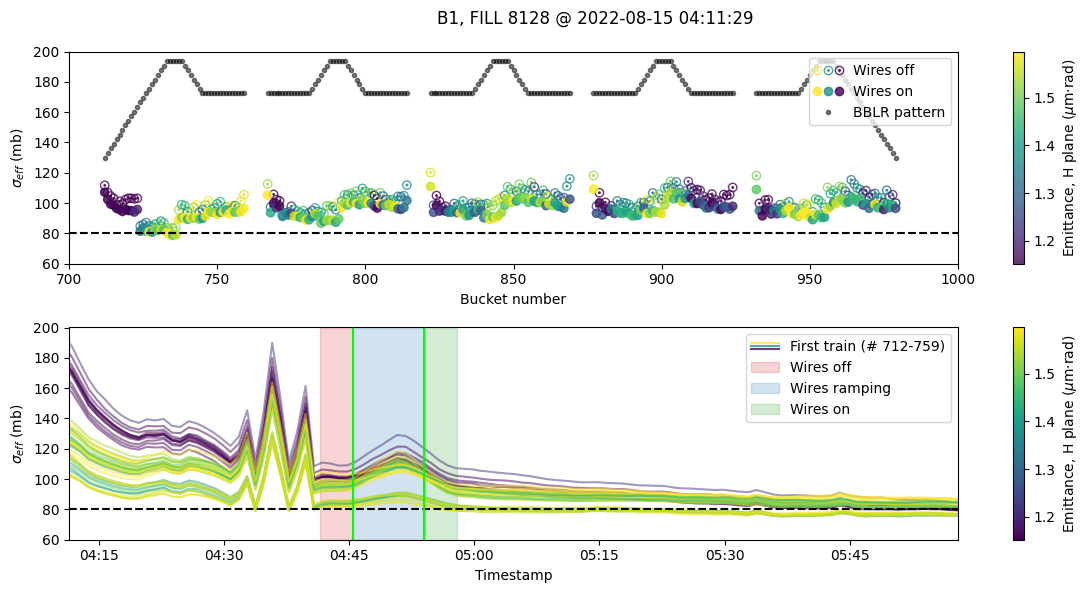

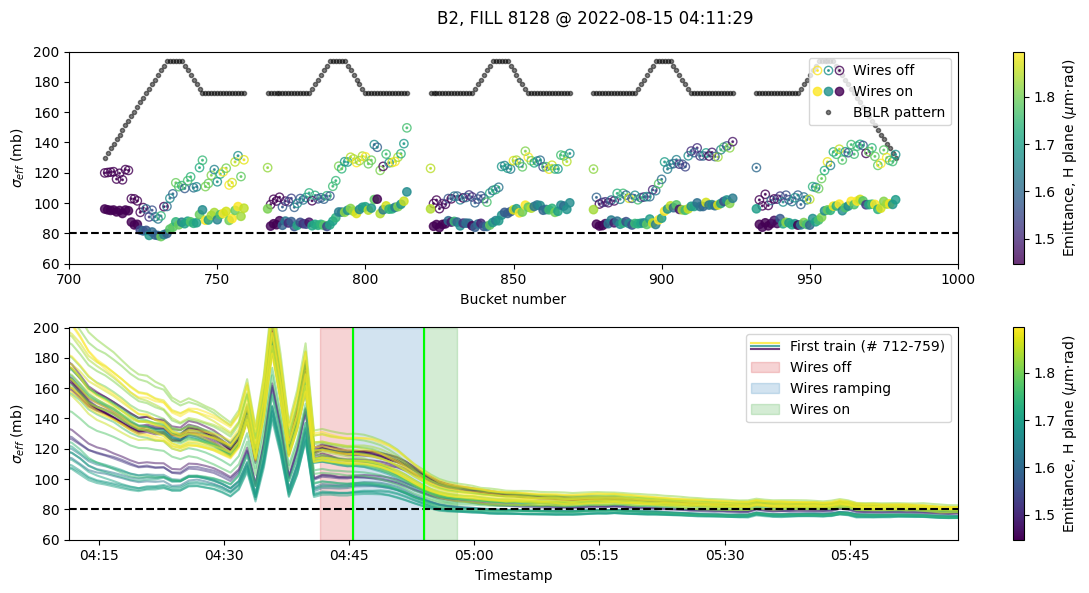

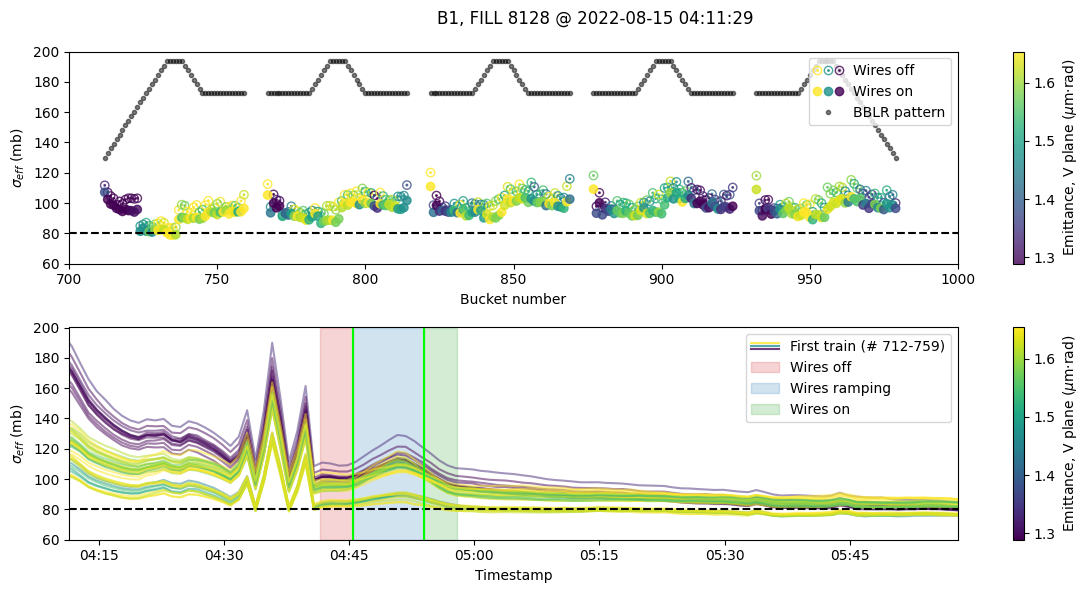

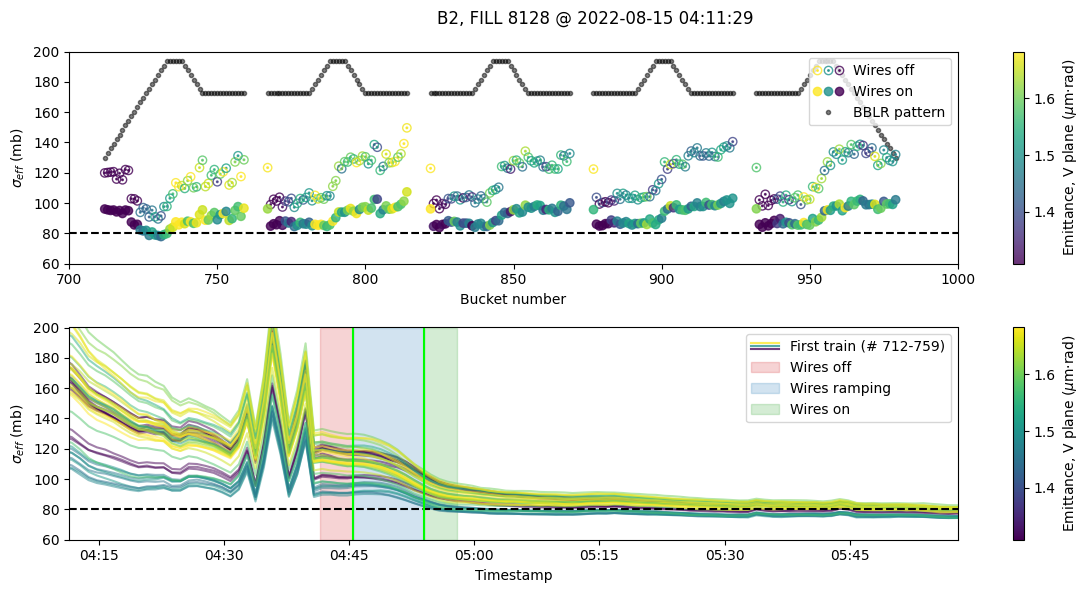

In [ ]:







for plane in ['H','V']:

    for beam,bb_df in zip(beams,[patt.b1.bb_schedule,patt.b2.bb_schedule]):

        # COLORCODED
        #===============================
        sc_label = f'Emittance, {plane} plane'+ ' ($\mu$m$\cdot$rad)'
        _colorby = bb_parameters.set_index('Timestamp')[f'bb_Emittance_{plane}_{beam.name}']
        # Figuring out colormap
        _,cgrid = _colorby[time_window[0]:time_window[1]].to_2D()
        cgrid = cgrid [:,bb_df.index]
        vmin = np.mean(cgrid)-1*np.std(cgrid)
        vmax = np.mean(cgrid)+1*np.std(cgrid)
        #===============================

        fig, axes = plt.subplots(figsize=(12,6),ncols=1, nrows=2,gridspec_kw={'height_ratios': [1, 1]})
        
        plt.sca(axes[0])
        ROI_Before = xsection_df[beam.name].set_index('Timestamp').loc[ t0:t1]
        ROI_After  = xsection_df[beam.name].set_index('Timestamp').loc[ t2:t3]

        
        # Before
        sc_alpha = 0.8
        sc = plt.scatter(buckets,ROI_Before['sig_eff'].mean()/1e-3, marker='.',s=5 ,c = _colorby[t2:t3].mean(),vmin=vmin,vmax=vmax,alpha=sc_alpha,cmap='viridis')
        plt.scatter(buckets,ROI_Before['sig_eff'].mean()/1e-3, facecolors='none',edgecolors=sc.to_rgba(_colorby[t2:t3].mean()),vmin=vmin,vmax=vmax,alpha=sc_alpha,cmap='viridis')
        # After
        plt.scatter(buckets,ROI_After['sig_eff'].mean()/1e-3 ,c = _colorby[t0:t1].mean(),vmin=vmin,vmax=vmax,alpha=sc_alpha,cmap='viridis')
        
        cbar = plt.colorbar()
        cbar.set_label(sc_label)

        # LEGEND
        #================================
        make_fun_legend()

        #================================


        plt.axhline(80,ls='--',color='k')
        plt.ylim([60,200])
        plt.xlim(choosen_bunches)
        plt.xlabel('Bucket number')
        plt.ylabel(r'$\sigma_{eff}$ (mb)')

        # ADDING  LR PATTERN IN BACKGROUND
        #==================================
        plt.gca().set_frame_on(False)
        ax2 = plt.gca().twinx()
        ax2.set_zorder(-1)
        ax2.get_yaxis().set_visible(False)
        LRcount = np.nan*np.zeros(len(buckets))
        LRcount[bb_df.index] = bb_df['# of LR in ATLAS/CMS']
        plt.plot(buckets,LRcount,'.k',alpha=0.5,zorder=-10)
        #plt.plot(buckets[middles],LRcount[middles],'o',color='C1',alpha=0.8,zorder=-8)
        #plt.ylabel(r'Number of LR')
        #==================================


        plt.sca(axes[1])

        TrainOI       = bb_df.loc[choosen_bunches[0]:]['Train'].iloc[0]
        study_bunches = bb_df.groupby('Train').get_group(TrainOI).index

        for tagged,info,color in zip([study_bunches],['nothing'],['C1']):    
            for bunch in tagged:

                ts       = xsection_df[beam.name]['Timestamp']
                xsection = xsection_df[beam.name]['sig_eff'].apply(lambda line:line[bunch])
                lifetime = xsection_df[beam.name]['Lifetime'].apply(lambda line:line[bunch])

                ts_smooth       = xsection_smooth_df[beam.name]['Timestamp']
                xsection_smooth = xsection_smooth_df[beam.name]['sig_eff'].apply(lambda line:line[bunch])
                lifetime_smooth     = xsection_smooth_df[beam.name]['Lifetime'].apply(lambda line:line[bunch])

                #plt.plot(ts       ,xsection/1e-3       ,'.',alpha=0.2,color=color)
                #plt.plot(ts_smooth,xsection_smooth/1e-3,'-',alpha=0.5,color=color)

                # Creating color distribution with scatter
                bunch_color =  _colorby.apply(lambda line:line[bunch])
                sc = plt.scatter(ts_smooth ,np.nan*xsection_smooth,c = bunch_color ,vmin=vmin,vmax=vmax,cmap='viridis')

                # Plotting smotthed lines
                plt.plot(ts_smooth, xsection_smooth/1e-3,'-',alpha=0.5,color=sc.to_rgba(np.mean(bunch_color[time_window[0]:time_window[1]])))


        cbar = plt.colorbar()
        cbar.set_label(sc_label)

        plt.axhline(80,ls='--',color='k')
        plt.axvline(wire_start,color='lime')
        plt.axvline(wire_stop,color='lime')
        plt.fill_between([t0,t1], 0, 1, color='C3', alpha=0.2, transform=plt.gca().get_xaxis_transform(),label = 'Wires off')
        plt.fill_between([t1,t2], 0, 1, color='C0', alpha=0.2, transform=plt.gca().get_xaxis_transform(),label = 'Wires ramping')
        plt.fill_between([t2,t3], 0, 1, color='C2', alpha=0.2, transform=plt.gca().get_xaxis_transform(),label = 'Wires on')

        plt.ylim([60,200])
        plt.xlim(time_window)
        plt.ylabel(r'$\sigma_{eff}$ (mb)')
        plt.xlabel(r'Timestamp')

        # ADJUSTING LEGEND
        #====================================
        plt.legend()
        handles, labels = plt.gca().get_legend_handles_labels()
        line0, = plt.plot([np.nan],[np.nan],'-',alpha=0.5,color=sc.to_rgba(+np.inf))
        line1, = plt.plot([np.nan],[np.nan],'-',alpha=0.5,color=sc.to_rgba(np.mean(cgrid)))
        line2, = plt.plot([np.nan],[np.nan],'-',alpha=0.5,color=sc.to_rgba(-np.inf))

        plt.legend([(line0,line1, line2)]+handles, 
                    [f'First train (# {study_bunches[0]}-{study_bunches[-1]})']+labels,
                    handler_map = {tuple : HandlerTupleVertical()})
        #====================================

        plt.suptitle(f'{beam.name}, FILL {FILL} @ {str(time_window[0])[:19]}')
        plt.tight_layout()
        
        plt.savefig(f'../Results_Lumi_V2/Presentations/colored_Emitt_F{FILL}_{beam.name}_{plane}.png',dpi=300)



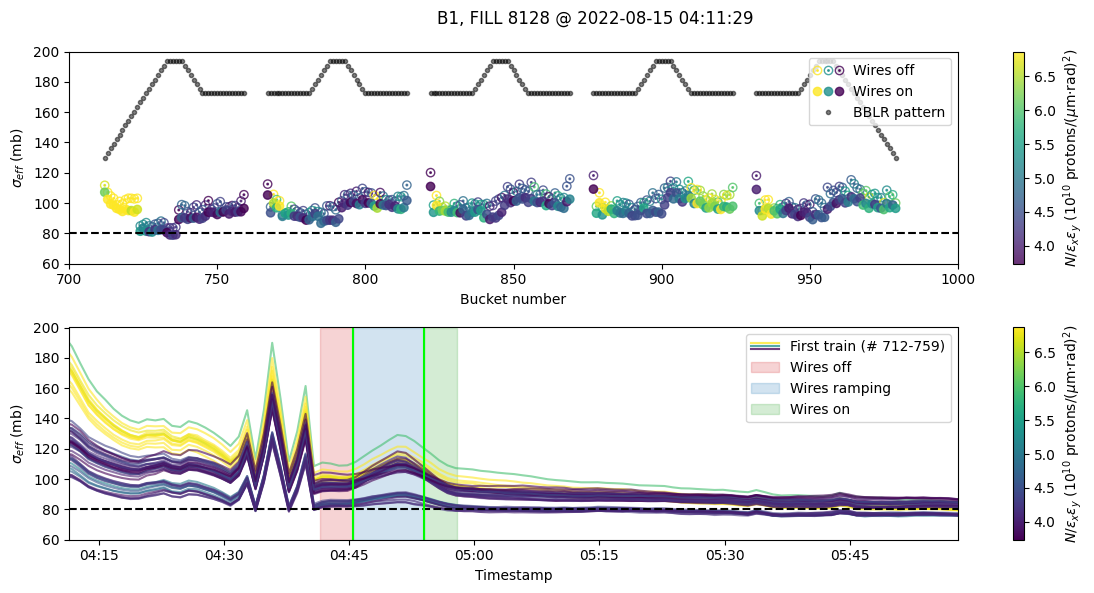

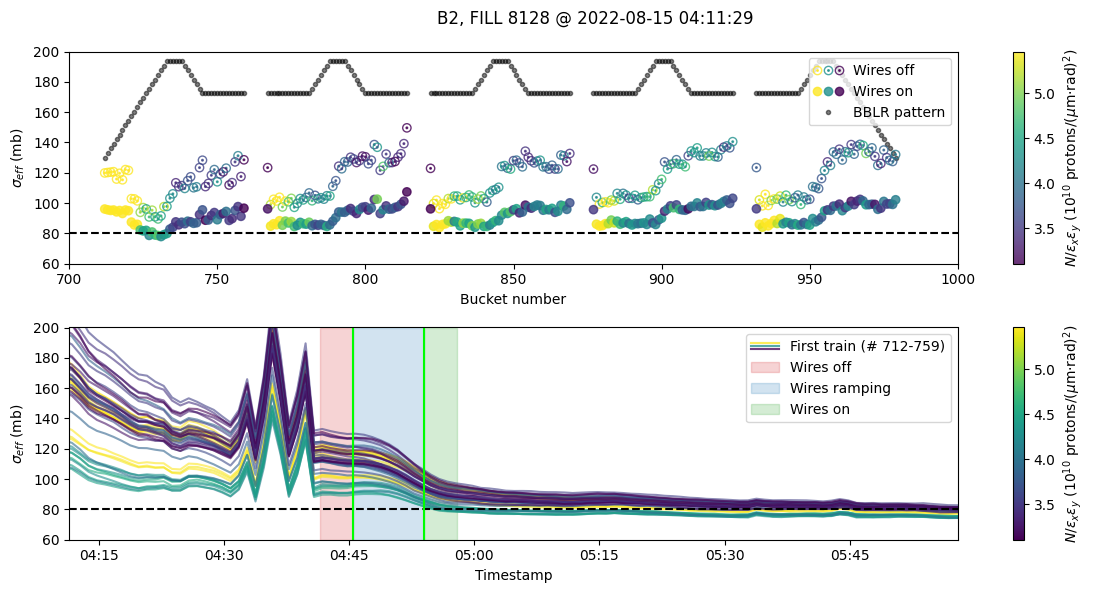

In [ ]:




for beam,bb_df in zip(beams,[patt.b1.bb_schedule,patt.b2.bb_schedule]):

    # COLORCODED
    #===============================
    sc_label = r'$N/\varepsilon_x\varepsilon_y$ ($10^{10}$ protons/($\mu$m$\cdot$rad$)^2$)'
    
    _N    = bb_parameters.set_index('Timestamp')[f'bb_Intensity_avg_{beam.name}']
    _epsx = bb_parameters.set_index('Timestamp')[f'bb_Emittance_H_{beam.name}']
    _epsy = bb_parameters.set_index('Timestamp')[f'bb_Emittance_V_{beam.name}']
    
    _colorby = _N/(_epsx*_epsy)/1e10
    # Figuring out colormap
    _,cgrid = _colorby[time_window[0]:time_window[1]].to_2D()
    cgrid = cgrid [:,bb_df.index]
    vmin = np.mean(cgrid)-1*np.std(cgrid)
    vmax = np.mean(cgrid)+1*np.std(cgrid)
    #===============================

    fig, axes = plt.subplots(figsize=(12,6),ncols=1, nrows=2,gridspec_kw={'height_ratios': [1, 1]})
    
    plt.sca(axes[0])
    ROI_Before = xsection_df[beam.name].set_index('Timestamp').loc[ t0:t1]
    ROI_After  = xsection_df[beam.name].set_index('Timestamp').loc[ t2:t3]

    
    # Before
    sc_alpha = 0.8
    sc = plt.scatter(buckets,ROI_Before['sig_eff'].mean()/1e-3, marker='.',s=5 ,c = _colorby[t2:t3].mean(),vmin=vmin,vmax=vmax,alpha=sc_alpha,cmap='viridis')
    plt.scatter(buckets,ROI_Before['sig_eff'].mean()/1e-3, facecolors='none',edgecolors=sc.to_rgba(_colorby[t2:t3].mean()),vmin=vmin,vmax=vmax,alpha=sc_alpha,cmap='viridis')
    # After
    plt.scatter(buckets,ROI_After['sig_eff'].mean()/1e-3 ,c = _colorby[t0:t1].mean(),vmin=vmin,vmax=vmax,alpha=sc_alpha,cmap='viridis')
    
    cbar = plt.colorbar()
    cbar.set_label(sc_label)

    # LEGEND
    #================================
    make_fun_legend()

    #================================


    plt.axhline(80,ls='--',color='k')
    plt.ylim([60,200])
    plt.xlim(choosen_bunches)
    plt.xlabel('Bucket number')
    plt.ylabel(r'$\sigma_{eff}$ (mb)')

    # ADDING  LR PATTERN IN BACKGROUND
    #==================================
    plt.gca().set_frame_on(False)
    ax2 = plt.gca().twinx()
    ax2.set_zorder(-1)
    ax2.get_yaxis().set_visible(False)
    LRcount = np.nan*np.zeros(len(buckets))
    LRcount[bb_df.index] = bb_df['# of LR in ATLAS/CMS']
    plt.plot(buckets,LRcount,'.k',alpha=0.5,zorder=-10)
    #plt.plot(buckets[middles],LRcount[middles],'o',color='C1',alpha=0.8,zorder=-8)
    #plt.ylabel(r'Number of LR')
    #==================================


    plt.sca(axes[1])

    TrainOI       = bb_df.loc[choosen_bunches[0]:]['Train'].iloc[0]
    study_bunches = bb_df.groupby('Train').get_group(TrainOI).index

    for tagged,info,color in zip([study_bunches],['nothing'],['C1']):  
        for bunch in tagged:

            ts       = xsection_df[beam.name]['Timestamp']
            xsection = xsection_df[beam.name]['sig_eff'].apply(lambda line:line[bunch])
            lifetime = xsection_df[beam.name]['Lifetime'].apply(lambda line:line[bunch])

            ts_smooth       = xsection_smooth_df[beam.name]['Timestamp']
            xsection_smooth = xsection_smooth_df[beam.name]['sig_eff'].apply(lambda line:line[bunch])
            lifetime_smooth     = xsection_smooth_df[beam.name]['Lifetime'].apply(lambda line:line[bunch])

            #plt.plot(ts       ,xsection/1e-3       ,'.',alpha=0.2,color=color)
            #plt.plot(ts_smooth,xsection_smooth/1e-3,'-',alpha=0.5,color=color)

            # Creating color distribution with scatter
            bunch_color =  _colorby.apply(lambda line:line[bunch])
            sc = plt.scatter(ts_smooth ,np.nan*xsection_smooth,c = bunch_color ,vmin=vmin,vmax=vmax,cmap='viridis')

            # Plotting smotthed lines
            plt.plot(ts_smooth, xsection_smooth/1e-3,'-',alpha=0.6,color=sc.to_rgba(np.mean(bunch_color[time_window[0]:time_window[1]])))


    cbar = plt.colorbar()
    cbar.set_label(sc_label)

    plt.axhline(80,ls='--',color='k')
    plt.axvline(wire_start,color='lime')
    plt.axvline(wire_stop,color='lime')
    plt.fill_between([t0,t1], 0, 1, color='C3', alpha=0.2, transform=plt.gca().get_xaxis_transform(),label = 'Wires off')
    plt.fill_between([t1,t2], 0, 1, color='C0', alpha=0.2, transform=plt.gca().get_xaxis_transform(),label = 'Wires ramping')
    plt.fill_between([t2,t3], 0, 1, color='C2', alpha=0.2, transform=plt.gca().get_xaxis_transform(),label = 'Wires on')

    plt.ylim([60,200])
    plt.xlim(time_window)
    plt.ylabel(r'$\sigma_{eff}$ (mb)')
    plt.xlabel(r'Timestamp')
    
    # ADJUSTING LEGEND
    #====================================
    plt.legend()
    handles, labels = plt.gca().get_legend_handles_labels()
    line0, = plt.plot([np.nan],[np.nan],'-',alpha=0.5,color=sc.to_rgba(+np.inf))
    line1, = plt.plot([np.nan],[np.nan],'-',alpha=0.5,color=sc.to_rgba(np.mean(cgrid)))
    line2, = plt.plot([np.nan],[np.nan],'-',alpha=0.5,color=sc.to_rgba(-np.inf))

    plt.legend([(line0,line1, line2)]+handles, 
                [f'First train (# {study_bunches[0]}-{study_bunches[-1]})']+labels,
                handler_map = {tuple : HandlerTupleVertical()})
    #====================================

    plt.suptitle(f'{beam.name}, FILL {FILL} @ {str(time_window[0])[:19]}')
    plt.tight_layout()
    
    #plt.savefig(f'../Results_Lumi_V2/Presentations/AVG_F{FILL}_{beam.name}.png',dpi=300)
    plt.savefig(f'../Results_Lumi_V2/Presentations/colored_Int_emitt_F{FILL}_{beam.name}.png',dpi=300)



In [ ]:
sys.exit(0)

SystemExit: 0

/home/phbelang/abp/WireDAQ/py_wireDAQ/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
line0, = plt.plot([np.nan],[np.nan],'-',alpha=0.5,color=sc.to_rgba(-np.inf))
line1, = plt.plot([np.nan],[np.nan],'-',alpha=0.5,color=sc.to_rgba(np.mean(cgrid))
line2, = plt.plot([np.nan],[np.nan],'-',alpha=0.5,color=sc.to_rgba(+np.inf))

SyntaxError: invalid syntax (1608299282.py, line 3)

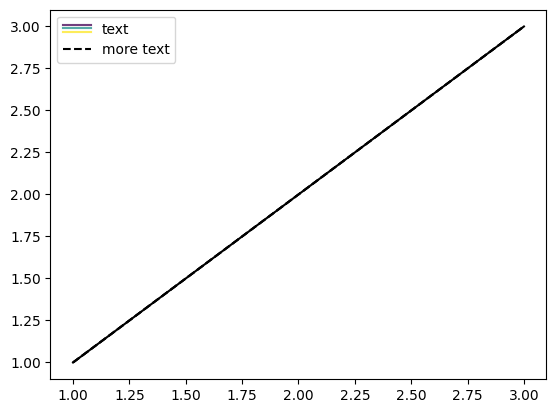

In [ ]:
line1, = plt.plot([1, 2.5, 3],[1, 2.5, 3], c='k', label='solid')
line2, = plt.plot([1, 2.5, 3],[1, 2.5, 3], c='k', ls='dashed', label='dashed')
line3, = plt.plot([1, 2.5, 3],[1, 2.5, 3], c='k', ls='dashed', label='dashed')




IndexError: list index out of range

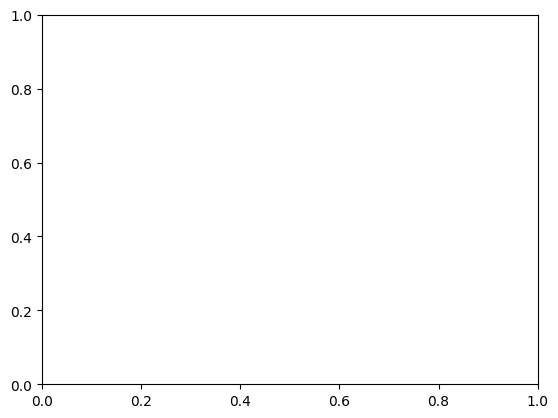

In [ ]:
handles, labels = plt.gca().get_legend_handles_labels()
list(handles)[1]

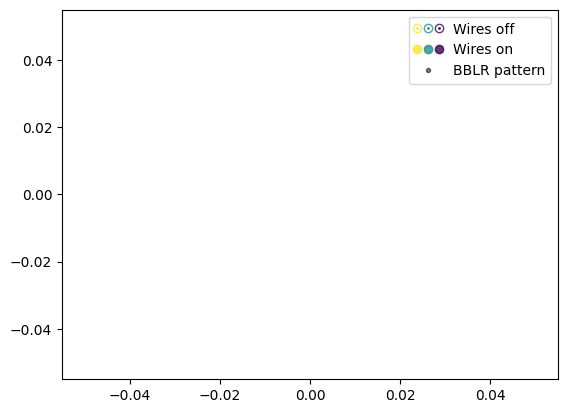

In [ ]:
plt.figure()



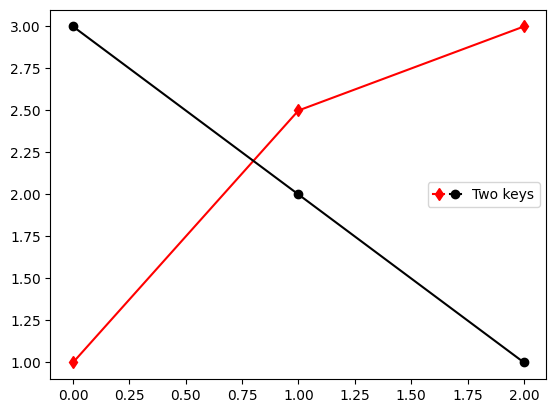

In [ ]:
from matplotlib.legend_handler import HandlerLine2D, HandlerTuple

fig, ax = plt.subplots()
p1, = ax.plot([1, 2.5, 3], 'r-d')
p2, = ax.plot([3, 2, 1], 'k-o')

l = ax.legend([(p1,p2)], ['Two keys'], numpoints=1,
              handler_map={tuple: HandlerTuple(ndivide=None)})

ValueError: Unrecognized character = in format string

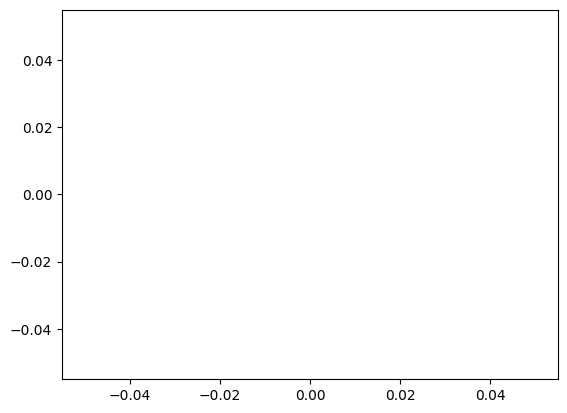

In [ ]:
plt.figure()
_dot,     = plt.plot([np.nan],[np.nan], '_',alpha=sc_alpha,ms=np.sqrt(5) ,color = sc.to_rgba(np.mean(cgrid)))
_circle,  = plt.plot([np.nan],[np.nan], '=',alpha=sc_alpha,mfc='none',color = sc.to_rgba(np.mean(cgrid)))
_regular, = plt.plot([np.nan],[np.nan], 'o',alpha=sc_alpha,color = sc.to_rgba(np.mean(cgrid)))
_LR,      = plt.plot([np.nan],[np.nan],'.k',alpha=0.5,label='Number of LR')
plt.legend([(_dot,_circle),_regular,_LR], ['Wires off','Wires on','BBLR pattern'])

# Old versions

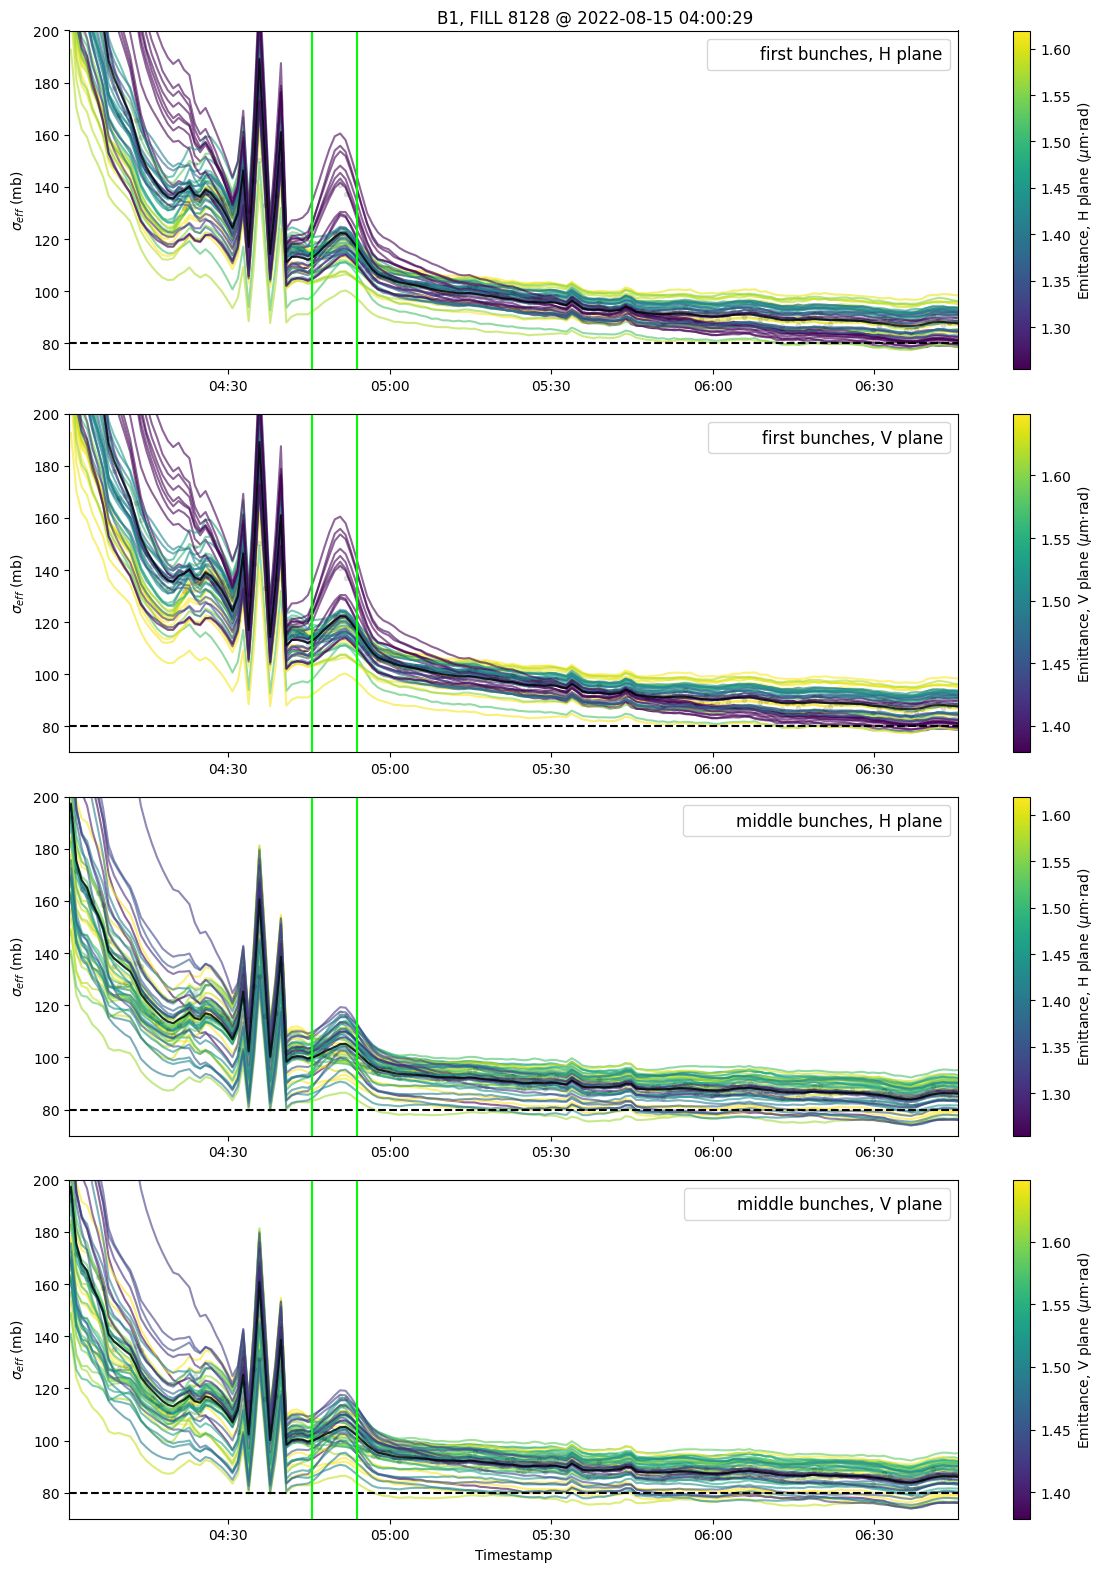

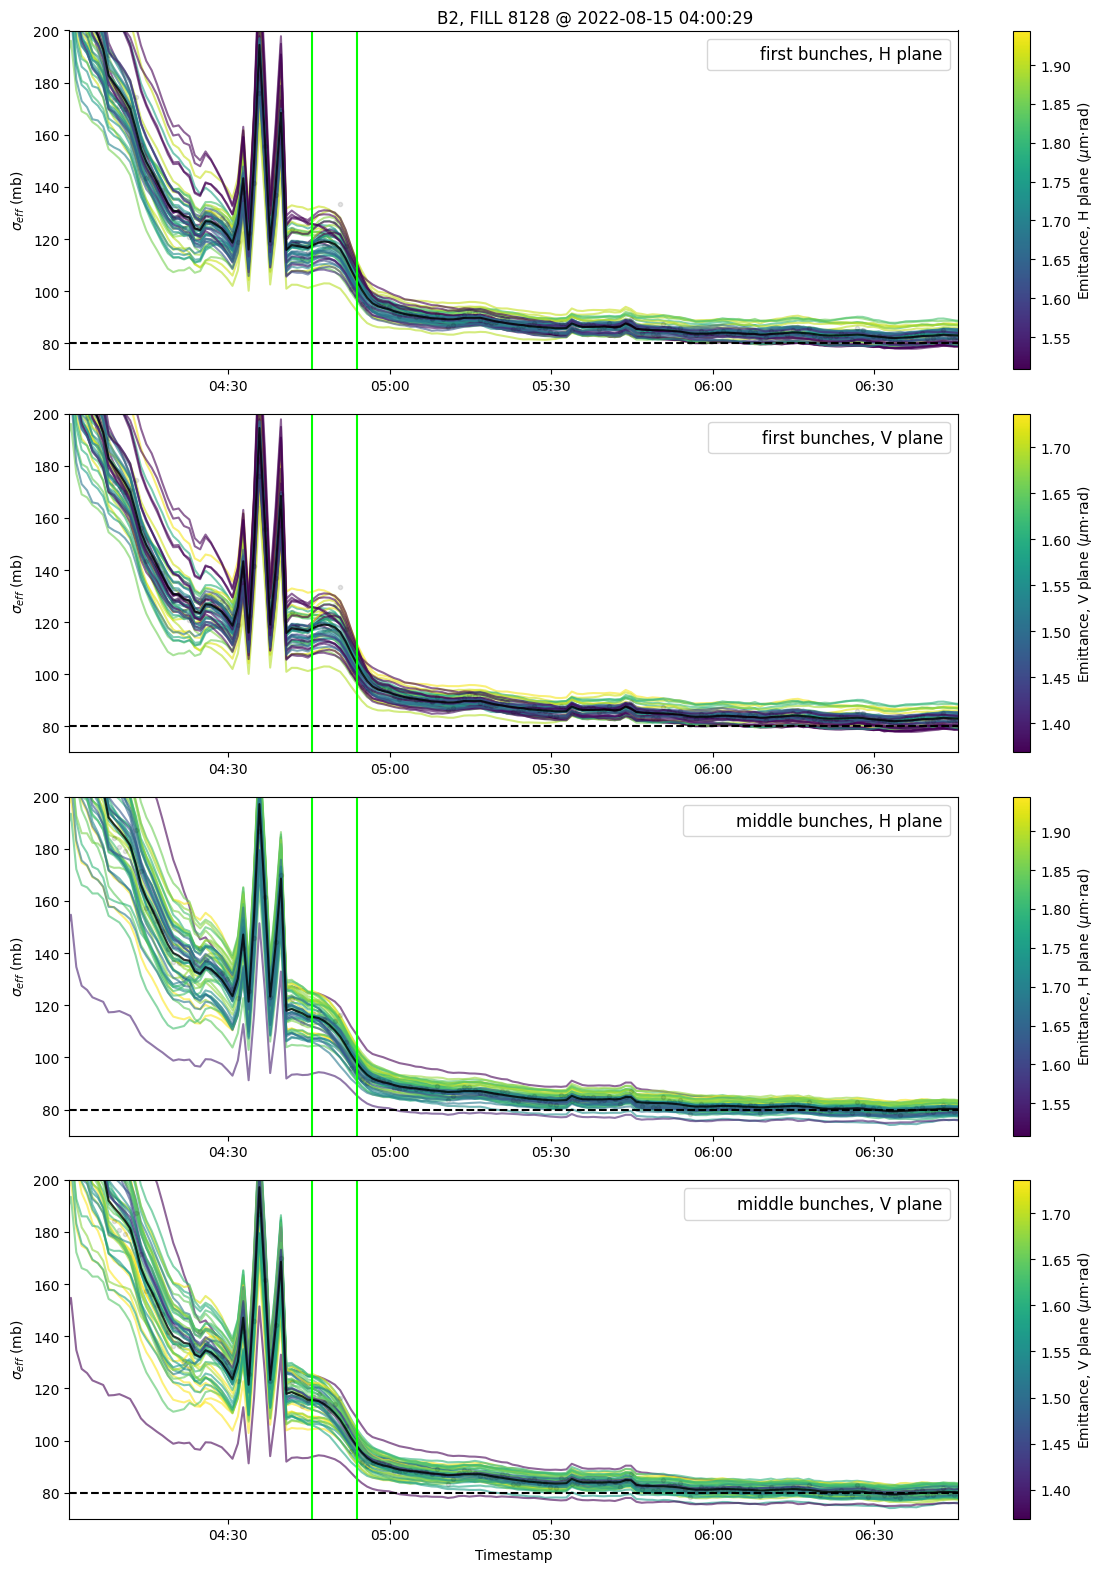

In [ ]:


#------------------------------------------

start_ts = database[database['HX:BMODE'] == 'STABLE']['Timestamp'].iloc[0]
if FILL == 8128:
    start_ts  = wire_start-pd.Timedelta(minutes=45)
stop_ts  = wire_start+pd.Timedelta(hours=2)

def Make_Fig(figsize= (FIGWIDTH,16)):
    fig, _axes = plt.subplots(figsize=figsize,ncols=1, nrows=4,gridspec_kw={'height_ratios': [1, 1,1,1]})

    axes = {'first,H'     :_axes[0],
            'first,V'     :_axes[1],
            'middle,H'    :_axes[2],
            'middle,V'    :_axes[3]}


    return fig,axes
#------------------------------------------



plt.close('all')


for beam,bb_df in zip(beams,[patt.b1.bb_schedule,patt.b2.bb_schedule]):

    



    firsts  =  bb_df.groupby('Tag').get_group('first').index
    middles =  bb_df.groupby('Tag').get_group('middle').index

    fig,axes = Make_Fig()
    plt.suptitle(f'{beam.name}, FILL {FILL} @ {str(start_ts)[:19]}')


    for tagged,info in zip([firsts,middles],['first','middle']):   
        

        for plane,axloc in zip(['H','V'],['top','bottom']):  

            # Extracting EMITTANCE
            _emitt    = bb_parameters.set_index('Timestamp')[f'bb_Emittance_{plane}_{beam.name}']

            # Figuring out colormap
            _,emittgrid = _emitt[start_ts:stop_ts].to_2D()
            emittgrid = emittgrid[:,list(firsts) + list(middles)]
            vmin = np.mean(emittgrid)-1*np.std(emittgrid)
            vmax = np.mean(emittgrid)+1*np.std(emittgrid)

            plt.sca(axes[f'{info},{plane}'])
            plt.plot([np.nan],[np.nan],'|',alpha=0,label=f'{info} bunches, {plane} plane')
            plt.legend(fontsize=12)
            for bunch in tagged:

                ts_smooth       = xsection_smooth_df[beam.name]['Timestamp']
                xsection_smooth = xsection_smooth_df[beam.name]['sig_eff'].apply(lambda line:line[bunch])
                lifetime_smooth = xsection_smooth_df[beam.name]['Lifetime'].apply(lambda line:line[bunch])


                # Creating color distribution with scatter
                bunch_emitt = _emitt.apply(lambda line:line[bunch])
                sc = plt.scatter(ts_smooth ,np.nan*xsection_smooth,c = bunch_emitt ,vmin=vmin,vmax=vmax,cmap='viridis')

                # Plotting smotthed lines
                plt.plot(ts_smooth, xsection_smooth/1e-3,'-',alpha=0.6,color=sc.to_rgba(np.mean(bunch_emitt[start_ts:stop_ts])))

            plt.axhline(80,ls='--',color='k')
            plt.ylim([70,200])
            plt.ylabel(r'$\sigma_{eff}$ (mb)')

            cbar = plt.colorbar()
            cbar.set_label(f'Emittance, {plane} plane'+ ' ($\mu$m$\cdot$rad)')

            # Computing avg
            avg_ts              = xsection_df[beam.name]['Timestamp']
            avg_xsection        = xsection_df[beam.name]['sig_eff'].apply(lambda line:np.mean(line[tagged]))
            avg_xsection_smooth = xsection_smooth_df[beam.name]['sig_eff'].apply(lambda line:np.mean(line[tagged]))
            
            plt.plot(avg_ts,avg_xsection/1e-3       ,'.',alpha=0.1,color='k')
            plt.plot(avg_ts,avg_xsection_smooth/1e-3,'-',alpha=0.8,color='k')

        

    for ax in axes.values():
        plt.sca(ax)
        plt.axvline(wire_start,color='lime')
        plt.axvline(wire_stop,color='lime')
        #plt.axvline(beta_reached,color='red')
        plt.xlim([start_ts,stop_ts])

    plt.xlabel('Timestamp')

    #plt.sca(axes['top'])
    #plt.plot([np.nan],[np.nan],color='k' ,alpha=0.5,label = 'Average')
    #plt.legend()

    #plt.sca(axes['bottom'])
    #plt.plot([np.nan],[np.nan],color='k' ,alpha=0.5,label = 'Average')
    #plt.legend()
    plt.tight_layout()
    
    plt.savefig(f'../Results_Lumi_V2/colorcoded/EMITT_F{FILL}_{beam.name}.png',dpi=300)

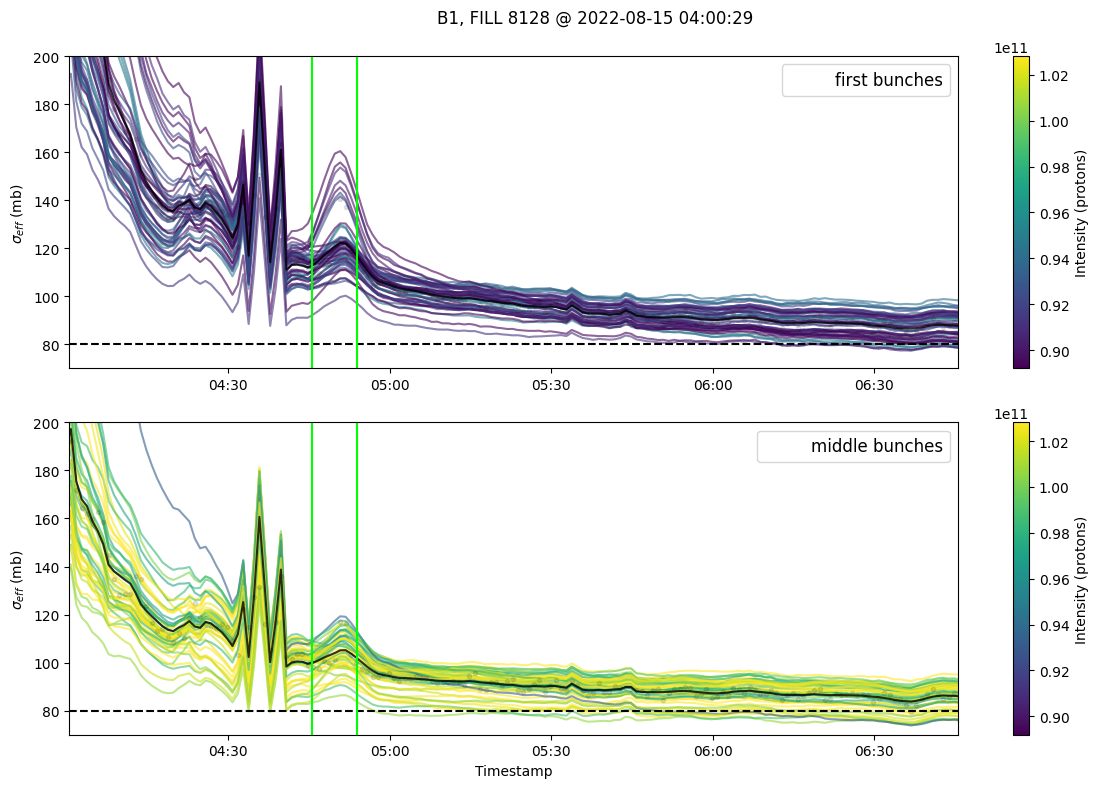

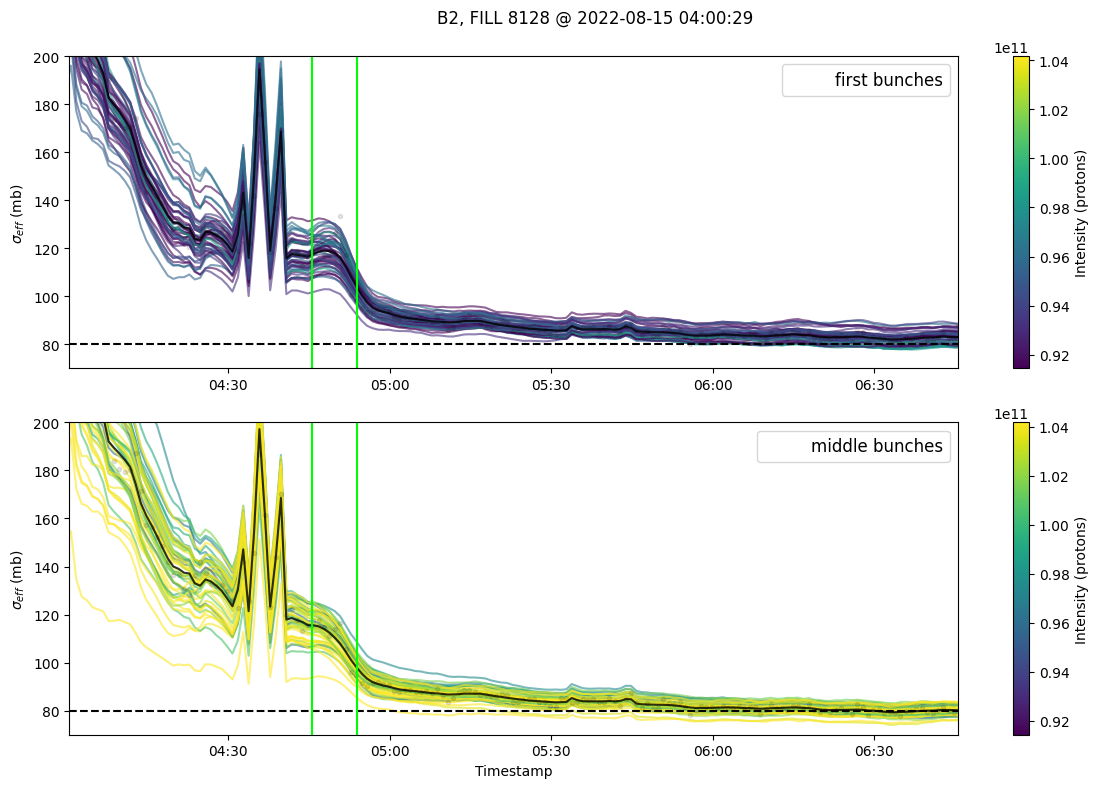

In [ ]:


#------------------------------------------

start_ts = database[database['HX:BMODE'] == 'STABLE']['Timestamp'].iloc[0]
if FILL == 8128:
    start_ts  = wire_start-pd.Timedelta(minutes=45)
stop_ts  = wire_start+pd.Timedelta(hours=2)

def Make_Fig(figsize= (FIGWIDTH,8)):
    fig, _axes = plt.subplots(figsize=figsize,ncols=1, nrows=2,gridspec_kw={'height_ratios': [1, 1]})

    axes = {'first'     :_axes[0],
            'middle'     :_axes[1]}


    return fig,axes
#------------------------------------------



plt.close('all')


for beam,bb_df in zip(beams,[patt.b1.bb_schedule,patt.b2.bb_schedule]):

    firsts  =  bb_df.groupby('Tag').get_group('first').index
    middles =  bb_df.groupby('Tag').get_group('middle').index

    fig,axes = Make_Fig()
    plt.suptitle(f'{beam.name}, FILL {FILL} @ {str(start_ts)[:19]}')


    for tagged,info in zip([firsts,middles],['first','middle']):   
        

         

        # Extracting EMITTANCE
        _emitt    = bb_parameters.set_index('Timestamp')[f'bb_Intensity_avg_{beam.name}'].dropna()

        # Figuring out colormap
        _,emittgrid = _emitt[start_ts:stop_ts].to_2D()
        emittgrid = emittgrid[:,list(firsts) + list(middles)]
        vmin = np.mean(emittgrid)-1*np.std(emittgrid)
        vmax = np.mean(emittgrid)+1*np.std(emittgrid)

        plt.sca(axes[f'{info}'])
        plt.plot([np.nan],[np.nan],'|',alpha=0,label=f'{info} bunches')
        plt.legend(fontsize=12)
        for bunch in tagged:

            ts_smooth       = xsection_smooth_df[beam.name]['Timestamp']
            xsection_smooth = xsection_smooth_df[beam.name]['sig_eff'].apply(lambda line:line[bunch])
            lifetime_smooth = xsection_smooth_df[beam.name]['Lifetime'].apply(lambda line:line[bunch])


            # Creating color distribution with scatter
            bunch_emitt = _emitt.apply(lambda line:line[bunch])
            sc = plt.scatter(ts_smooth ,np.nan*xsection_smooth,c = bunch_emitt ,vmin=vmin,vmax=vmax,cmap='viridis')

            # Plotting smotthed lines
            plt.plot(ts_smooth, xsection_smooth/1e-3,'-',alpha=0.6,color=sc.to_rgba(np.mean(bunch_emitt[start_ts:stop_ts])))

        plt.axhline(80,ls='--',color='k')
        plt.ylim([70,200])
        plt.ylabel(r'$\sigma_{eff}$ (mb)')

        cbar = plt.colorbar()
        cbar.set_label(f'Intensity (protons)')

        # Computing avg
        avg_ts              = xsection_df[beam.name]['Timestamp']
        avg_xsection        = xsection_df[beam.name]['sig_eff'].apply(lambda line:np.mean(line[tagged]))
        avg_xsection_smooth = xsection_smooth_df[beam.name]['sig_eff'].apply(lambda line:np.mean(line[tagged]))
        
        plt.plot(avg_ts,avg_xsection/1e-3       ,'.',alpha=0.1,color='k')
        plt.plot(avg_ts,avg_xsection_smooth/1e-3,'-',alpha=0.8,color='k')

        

    for ax in axes.values():
        plt.sca(ax)
        plt.axvline(wire_start,color='lime')
        plt.axvline(wire_stop,color='lime')
        #plt.axvline(beta_reached,color='red')
        plt.xlim([start_ts,stop_ts])

    plt.xlabel('Timestamp')

    #plt.sca(axes['top'])
    #plt.plot([np.nan],[np.nan],color='k' ,alpha=0.5,label = 'Average')
    #plt.legend()

    #plt.sca(axes['bottom'])
    #plt.plot([np.nan],[np.nan],color='k' ,alpha=0.5,label = 'Average')
    #plt.legend()
    plt.tight_layout()
    
    plt.savefig(f'../Results_Lumi_V2/colorcoded/INTENSITY_F{FILL}_{beam.name}.png',dpi=300)